In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.decomposition import NMF
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd
import ensemble as nmf


os.sys.path.append("")

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# load database
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
mouse = '4139265.3'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')|
                   df_mouse['Track'].str.match('TwoTower_foraging')]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [3]:
df_mouse

MouseName  DateFolder  SessionNumber              Track  RewardCount  \
1403  4139265.3  10_02_2019              1  TwoTower_foraging           60   
1405  4139265.3  10_02_2019              3  TwoTower_foraging           60   
1433  4139265.3  12_02_2019              2  TwoTower_foraging           90   
1455  4139265.3  15_02_2019              4  TwoTower_foraging           72   
1475  4139265.3  17_02_2019              2  TwoTower_foraging           81   
1495  4139265.3  19_02_2019              2  TwoTower_foraging           92   
1513  4139265.3  21_02_2019              2  TwoTower_foraging           90   
1522  4139265.3  22_02_2019              2  TwoTower_foraging           90   
1531  4139265.3  23_02_2019              2  TwoTower_foraging           93   
1537  4139265.3  24_02_2019              2  TwoTower_foraging           97   

      Imaging ImagingRegion   DateTime  \
1403        1           CA1 2019-02-10   
1405        1           CA1 2019-02-10   
1433        1           CA1 2019-02-12   
1455        1           CA1 2019-02-15   
1475        1           CA1 2019-02-17   
1495        1           CA1 2019-02-19   
1513        1           CA1 2019-02-21   
1522        1           CA1 2019-02-22   
1531        1           CA1 2019-02-23   
1537        1           CA1 2019-02-24   

                                              data file scanfile  \
1403  G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...     None   
1405  G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...     None   
1433  G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...     None   
1455  G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...     None   
1475  G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...     None   
1495  G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...     None   
1513  G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...     None   
1522  G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...     None   
1531  G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...     None   
1537  G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...     None   

                                                scanmat  \
1403  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...   
1405  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...   
1433  G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...   
1455  G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...   
1475  G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...   
1495  G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...   
1513  G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...   
1522  G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...   
1531  G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...   
1537  G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...   

                                              s2pfolder  
1403  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...  
1405  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...  
1433  G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...  
1455  G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...  
1475  G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...  
1495  G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...  
1513  G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...  
1522  G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...  
1531  G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...  
1537  G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...

In [4]:
# pick session
sess = df_mouse.iloc[-1]

In [12]:
# load trial mat
VRDat,C, S, A = pp.load_scan_sess(sess)
print(VRDat.shape,S.shape)
Smean = np.mean(S,axis=0)
S /= Smean[np.newaxis,:]
Ssm = sp.ndimage.filters.gaussian_filter(S,[5,0])
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)



num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
(32038, 22) (32038, 1634)


In [13]:
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds,bin_size=10)
S_trial_mat = sp.ndimage.filters.gaussian_filter(S_trial_mat,[0,2,0])

In [14]:
# get rate map in two extremes, smooth and subtract them
CD=np.squeeze(np.nanmedian(S_trial_mat[trial_info['morphs']==1,:,:],axis=0)-np.nanmedian(S_trial_mat[trial_info['morphs']==0,:,:],axis=0))
CD/=np.linalg.norm(CD,2,axis=1)[:,np.newaxis]
S_norm = S/(np.linalg.norm(S,2,axis=1)[:,np.newaxis]+.0001)
print(CD.shape)

(45, 1634)


In [58]:
# project data at every time point onto the appropriate vector
pos_binned = np.digitize(VRDat.pos._values,edges)
# ignore first and last inds
inds = pos_binned-1
#mask = (pos_binned>0) & (pos_binned<45)
CDmat = np.zeros(S.shape)
for t in range(S.shape[0]):
    if pos_binned[t]>0 and pos_binned[t]<46:
        CDmat = CD[inds[t],:]


In [59]:
PROJ = np.multiply(S_norm,CDmat).sum(axis=1)

In [17]:
#effMorph = VRDat.morph._values+VRDat.bckgndJitter._values+VRDat

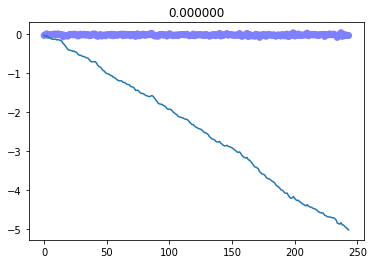

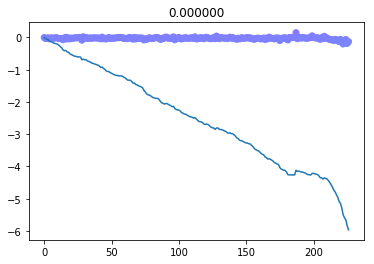

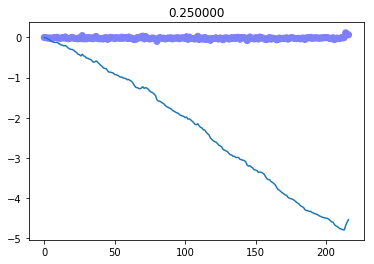

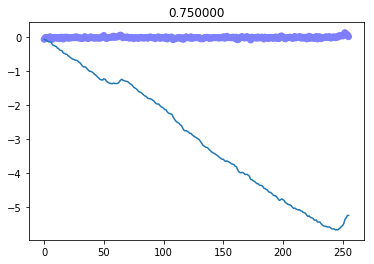

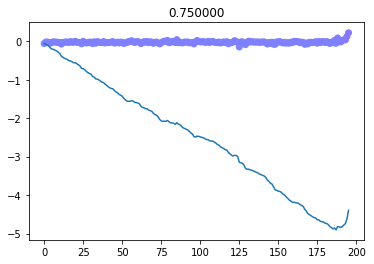

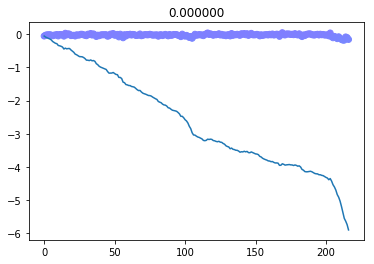

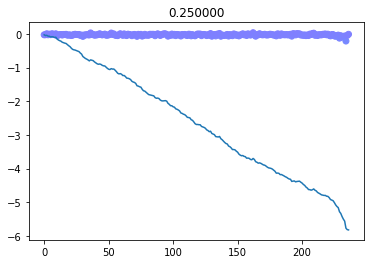

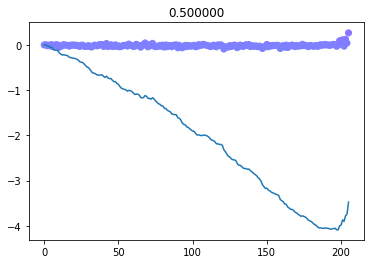

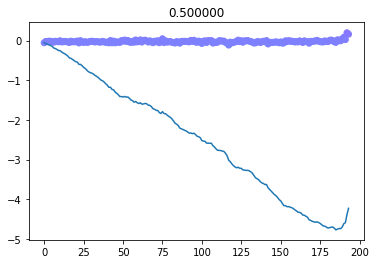

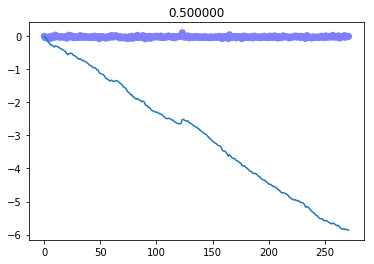

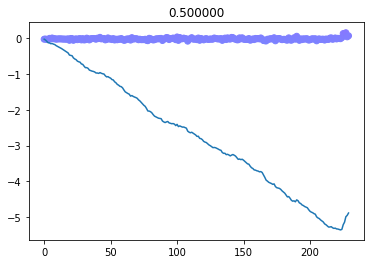

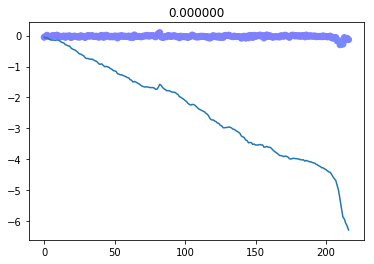

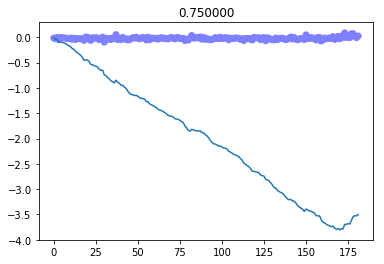

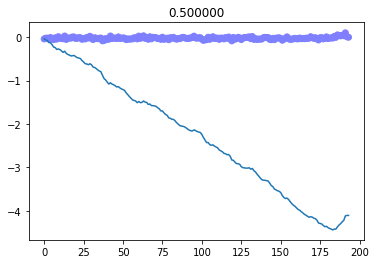

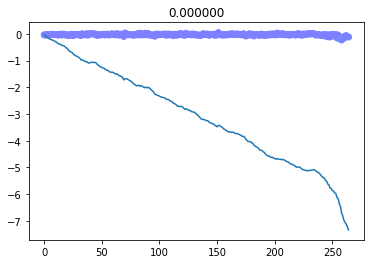

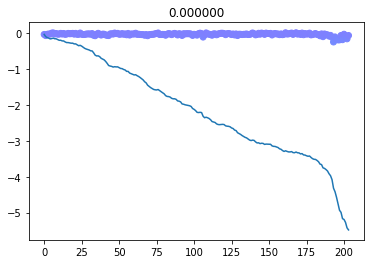

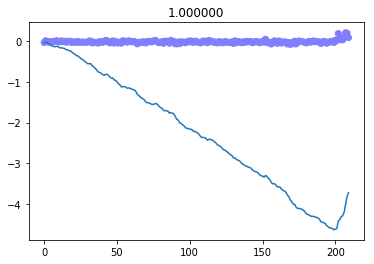

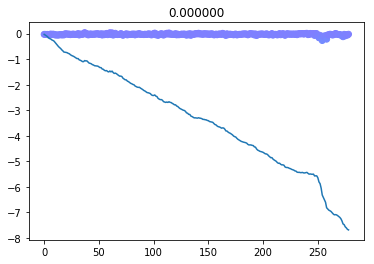

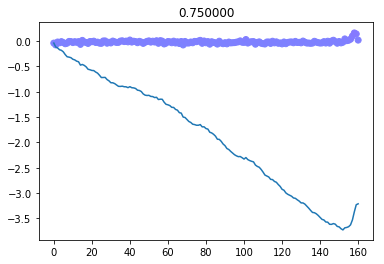

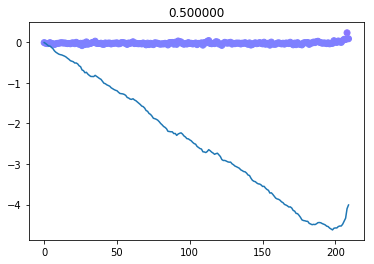

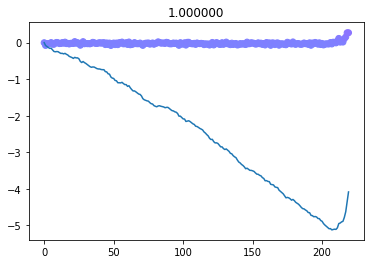

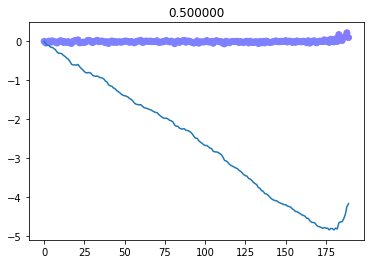

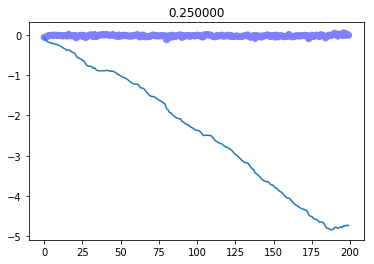

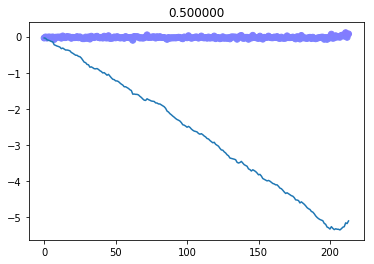

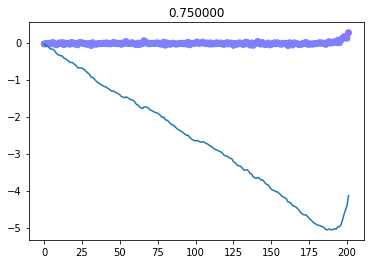

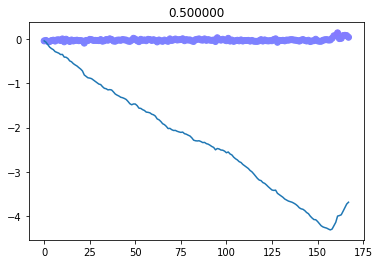

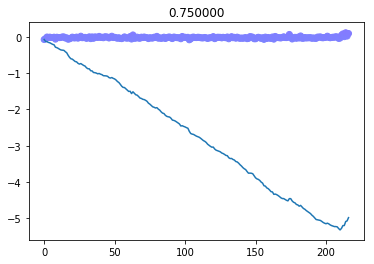

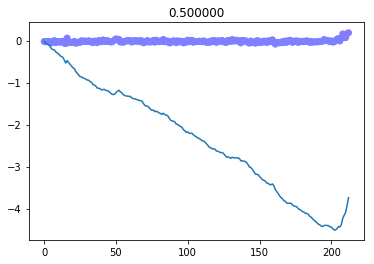

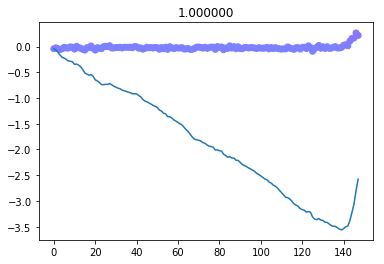

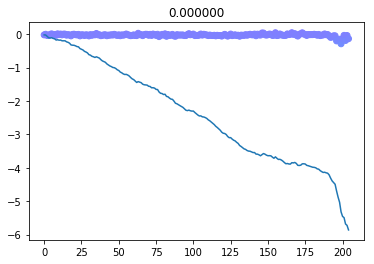

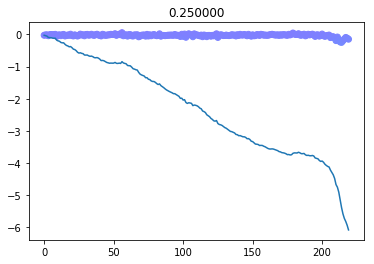

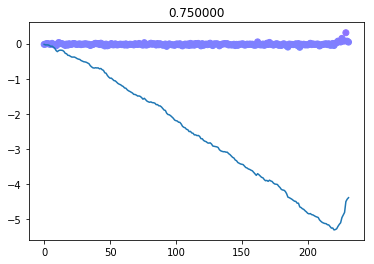

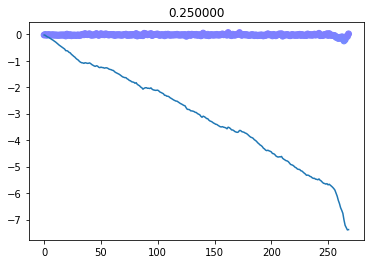

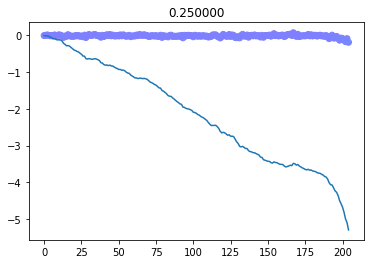

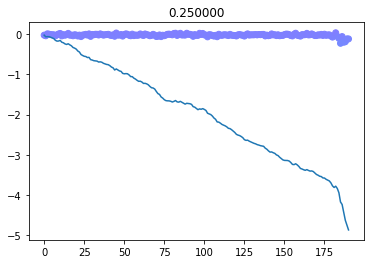

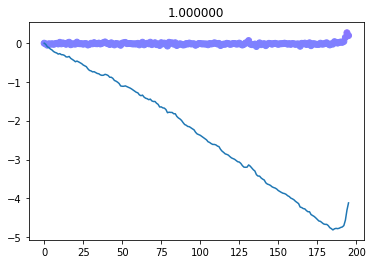

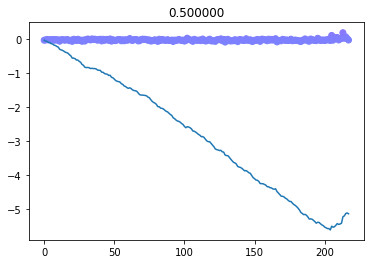

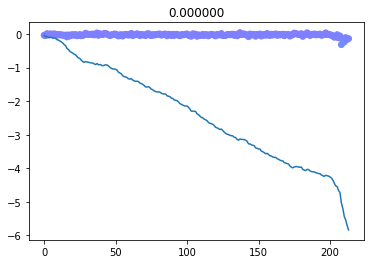

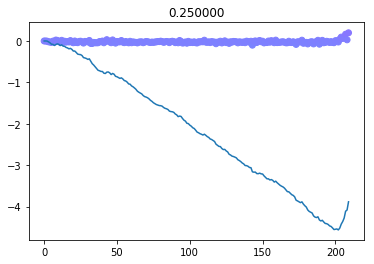

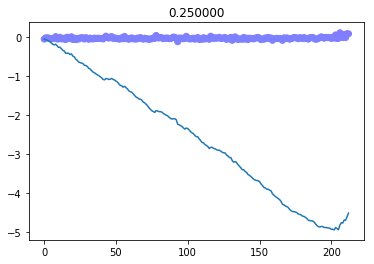

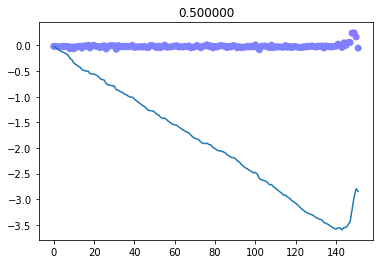

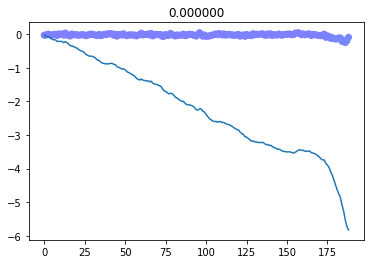

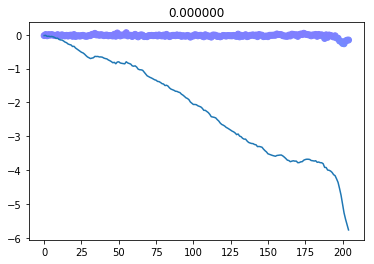

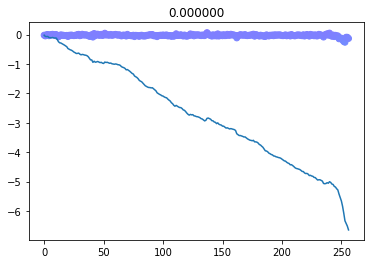

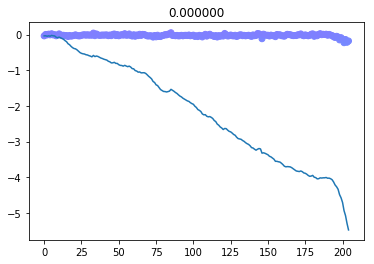

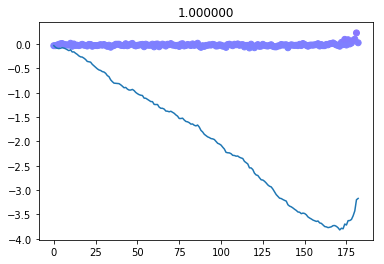

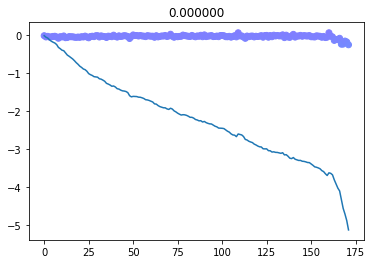

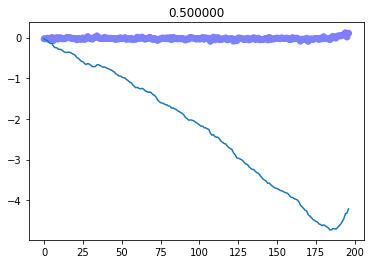

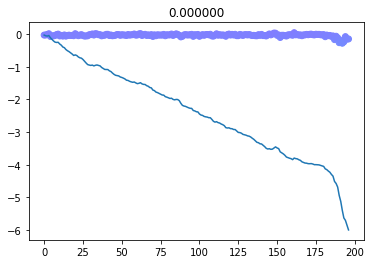

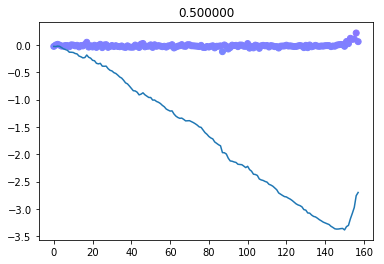

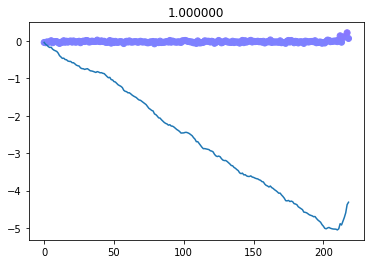

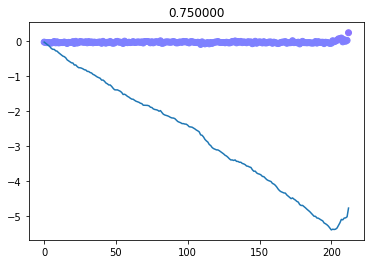

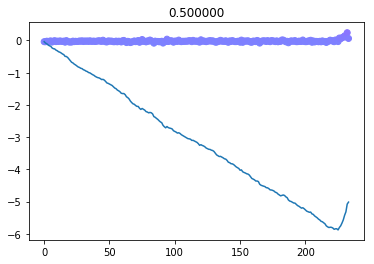

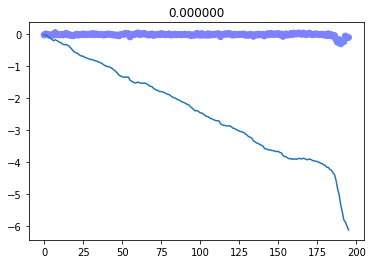

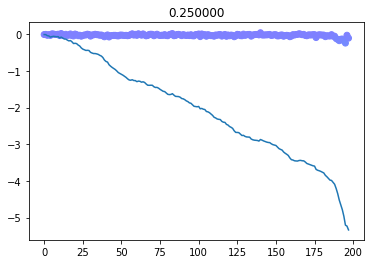

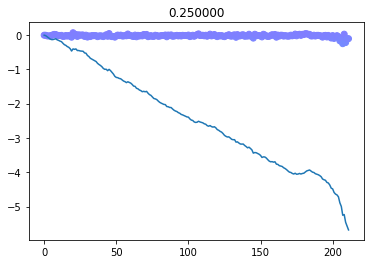

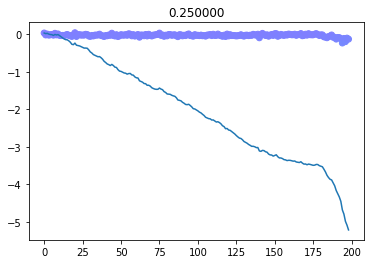

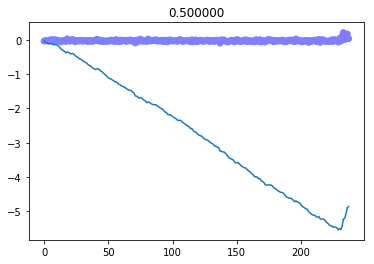

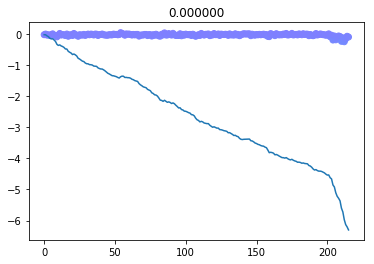

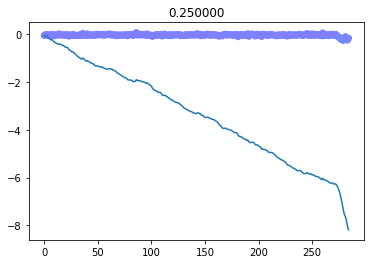

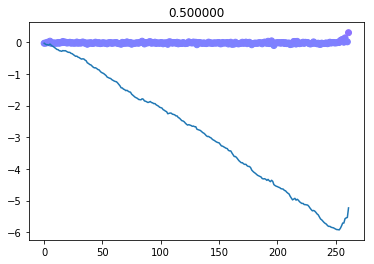

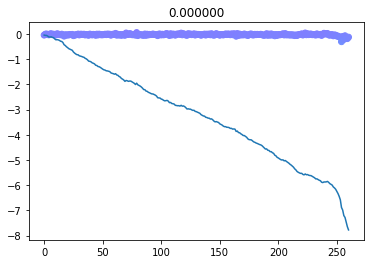

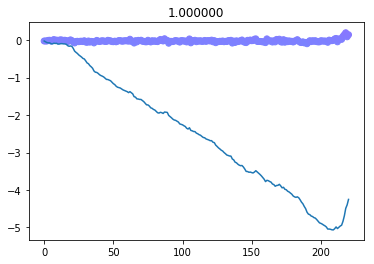

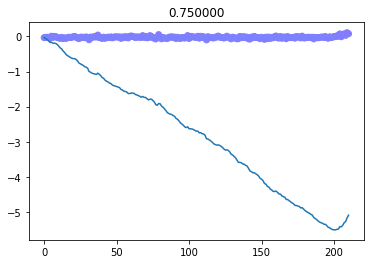

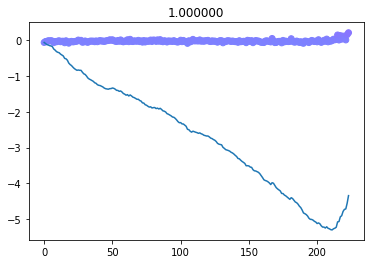

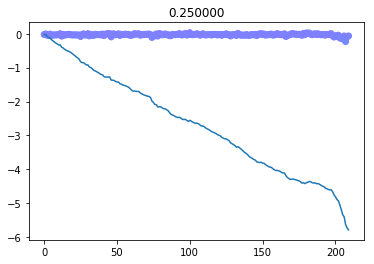

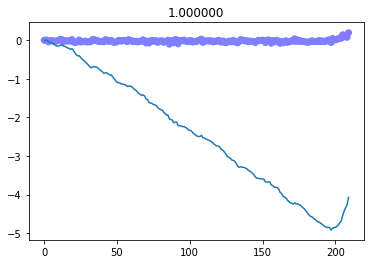

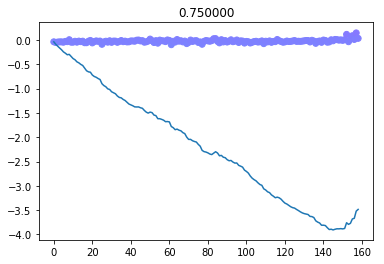

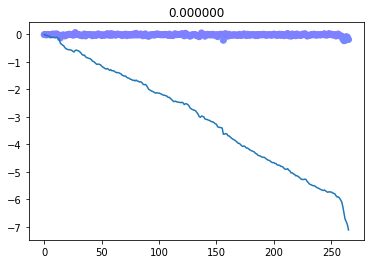

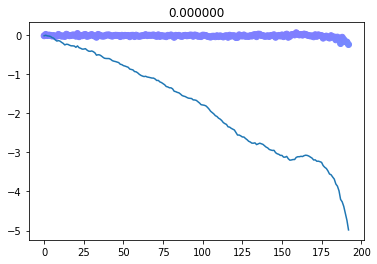

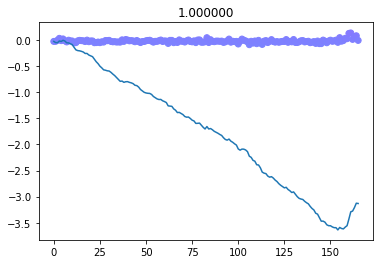

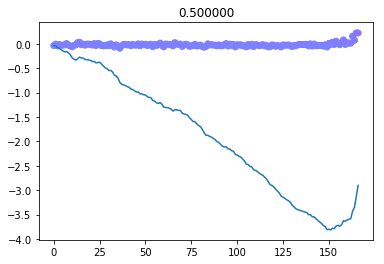

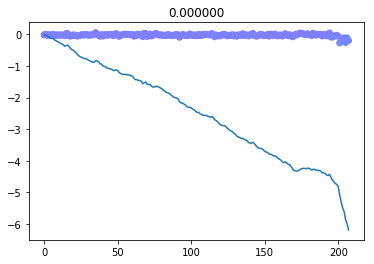

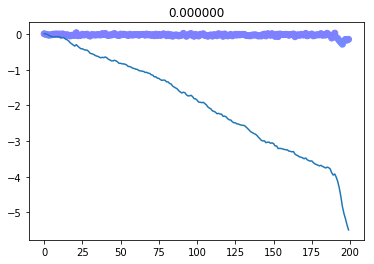

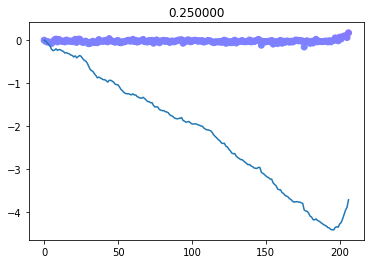

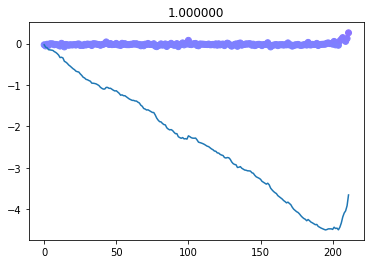

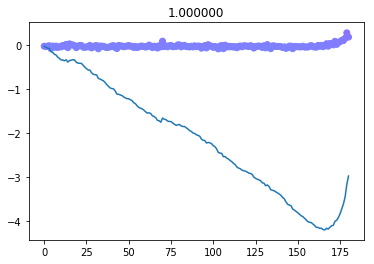

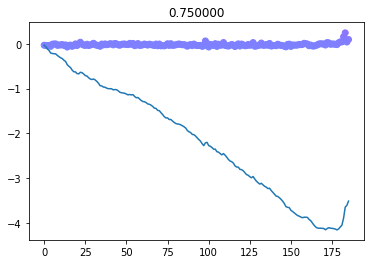

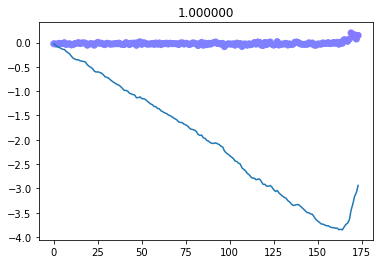

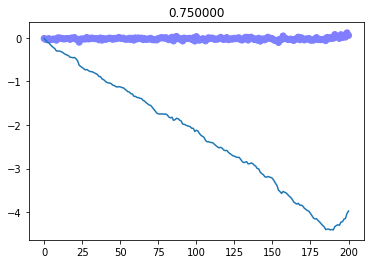

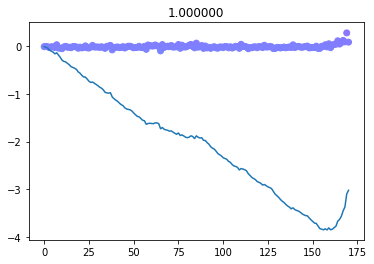

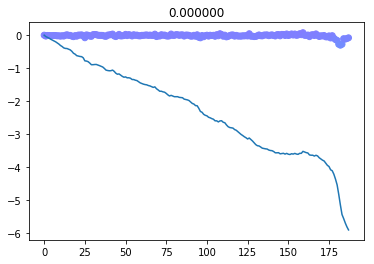

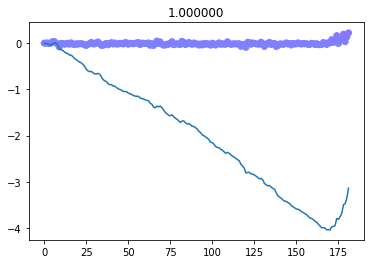

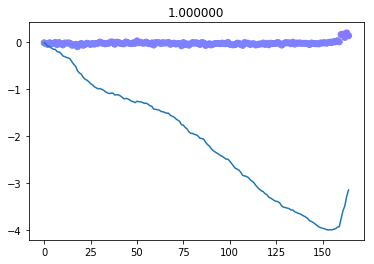

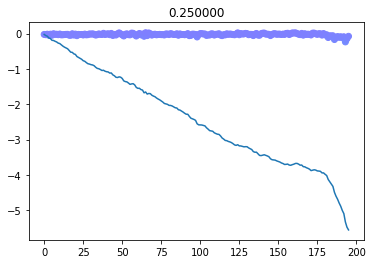

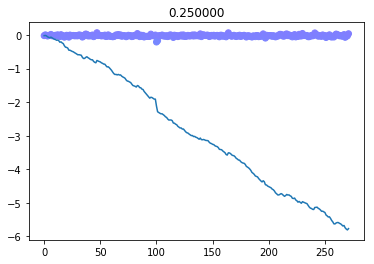

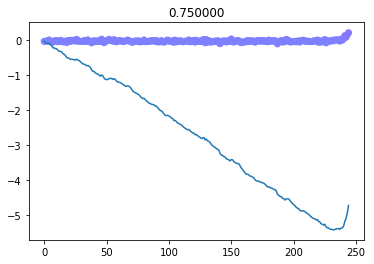

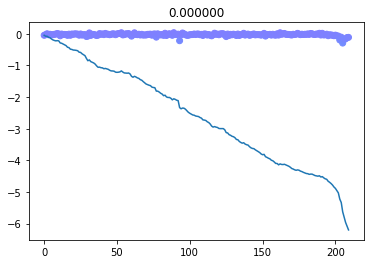

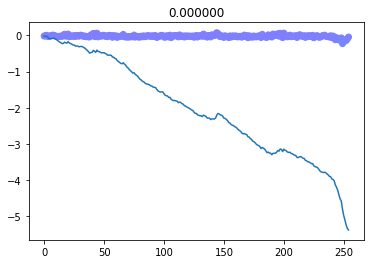

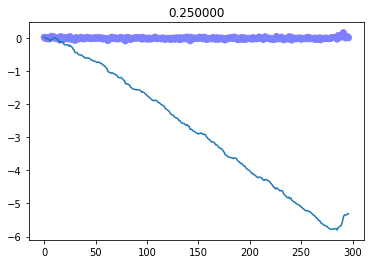

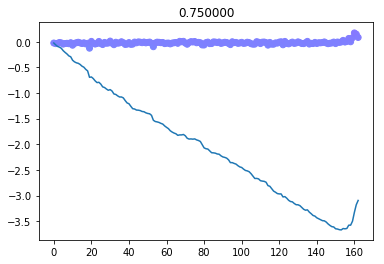

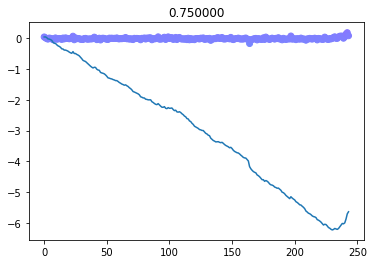

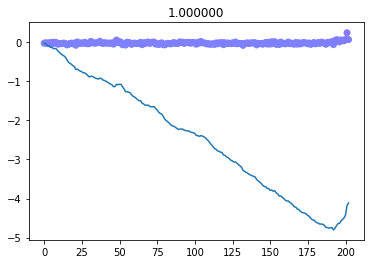

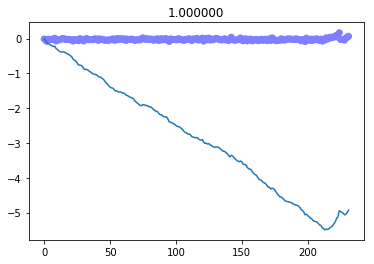

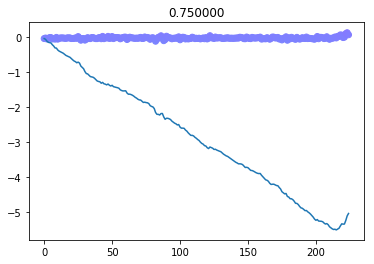

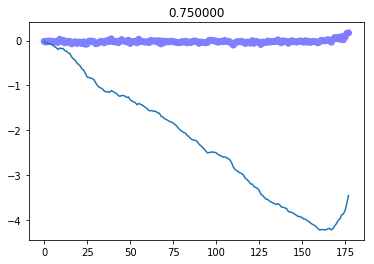

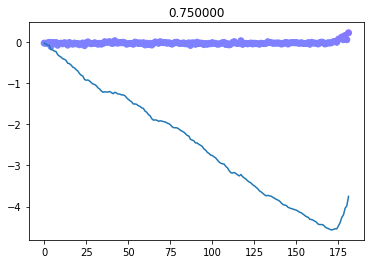

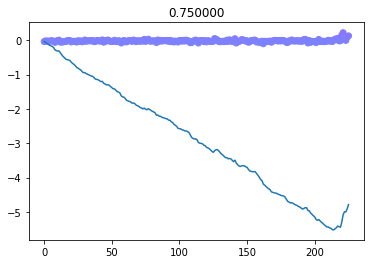

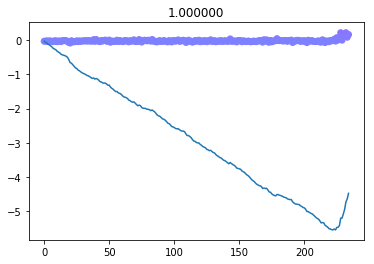

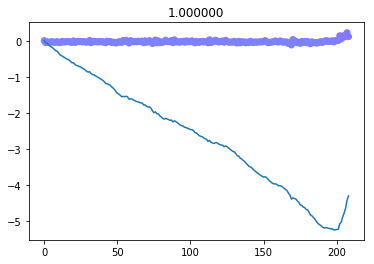

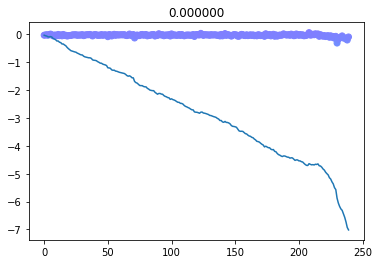

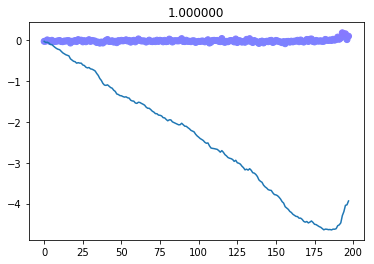

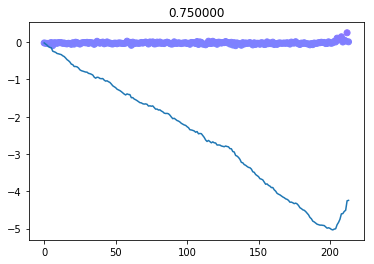

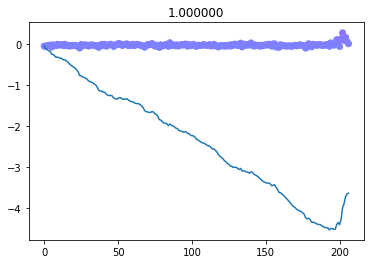

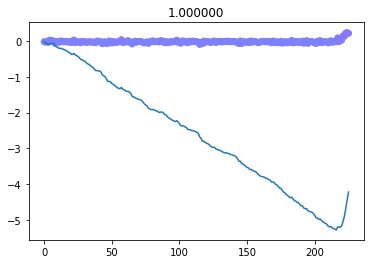

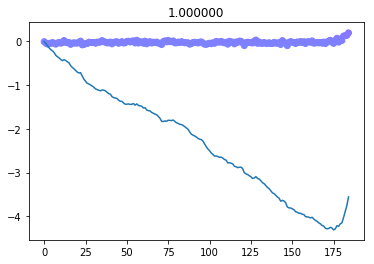

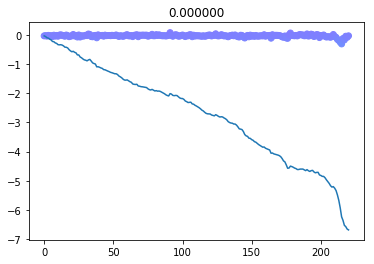

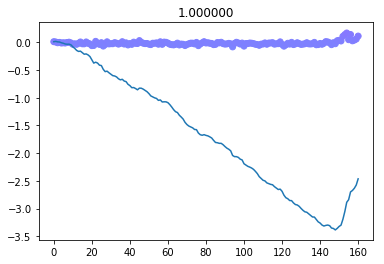

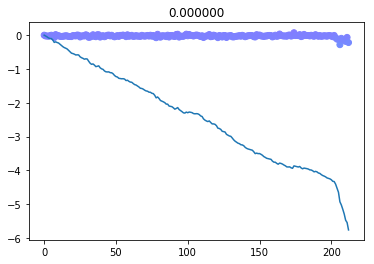

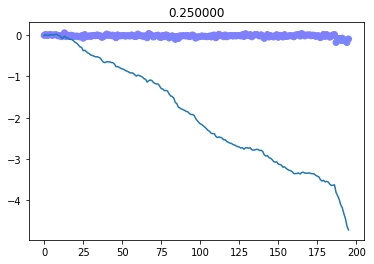

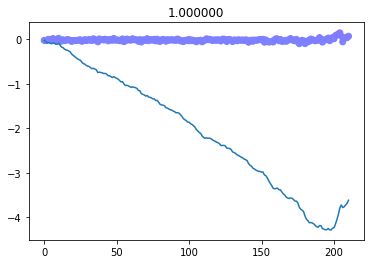

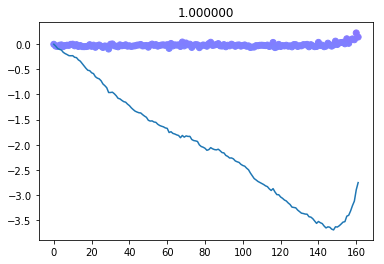

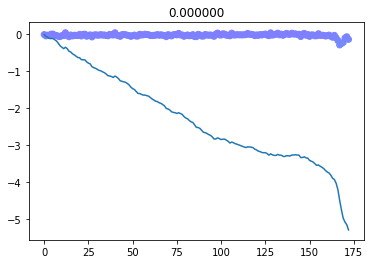

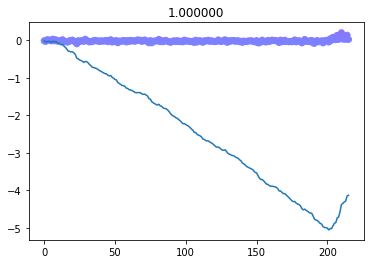

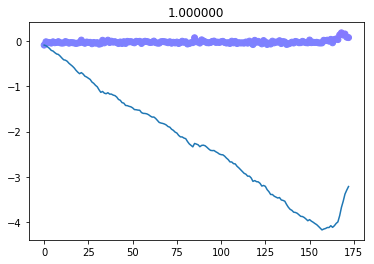

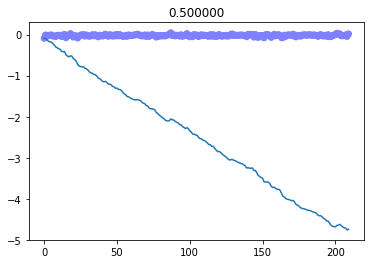

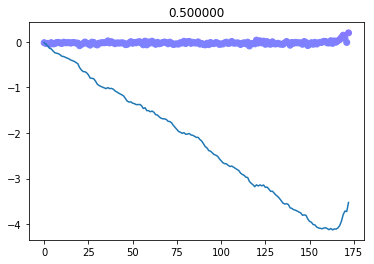

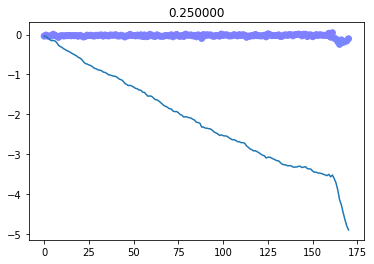

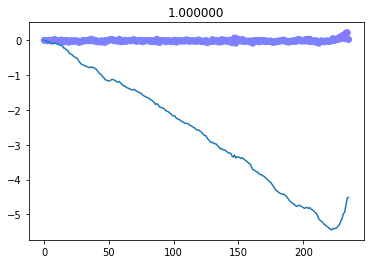

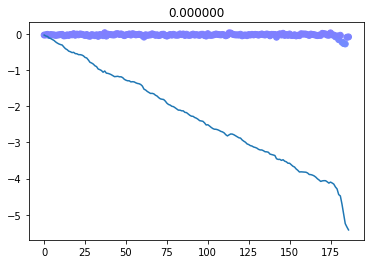

In [19]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.scatter(np.arange(stop-1-start),PROJ[start:stop-1],c=PROJ[start:stop-1],cmap='cool',vmin=-3,vmax=3)
    ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
#     ax.set_ylim([-.5,.5])

In [12]:
print(centers.shape)

(23,)


In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

In [21]:
mask = ((VRDat.morph._values==0) | (VRDat.morph._values==1.)) & (VRDat.pos._values>0)

In [22]:
lda = LDA()
lda.fit(S[mask,:],VRDat.morph._values[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [23]:
PROJ = lda.predict_proba(Ssm) #transform(S)

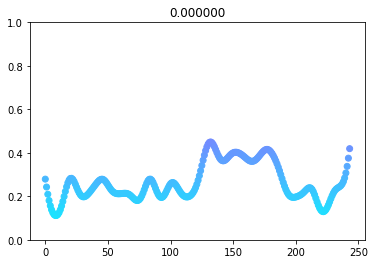

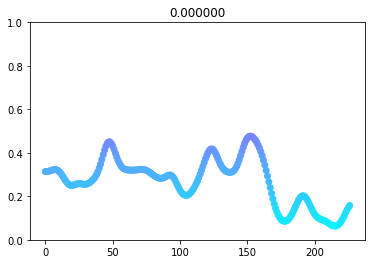

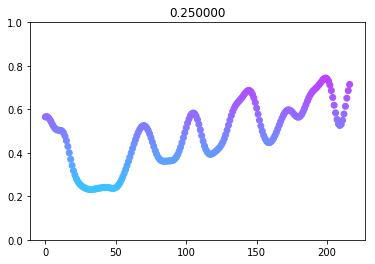

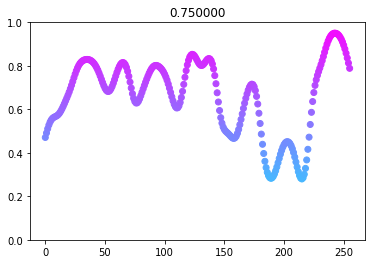

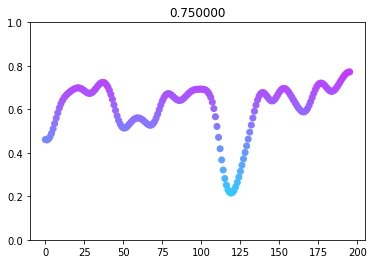

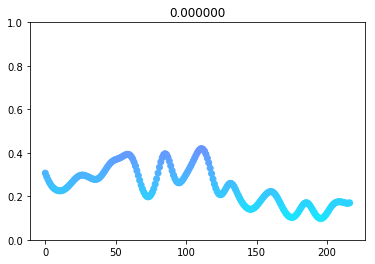

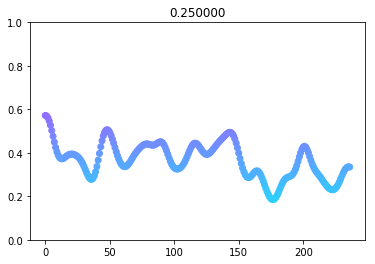

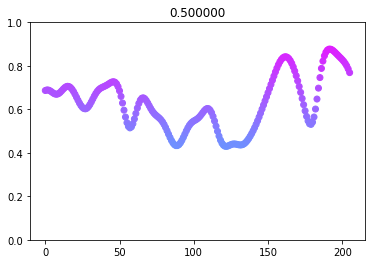

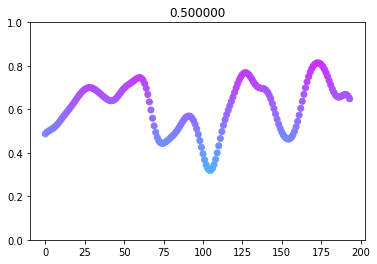

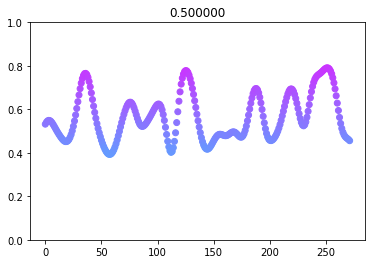

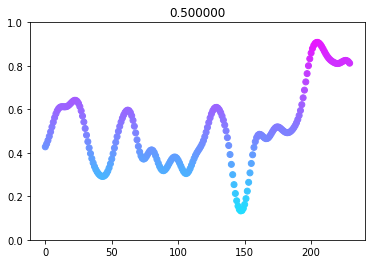

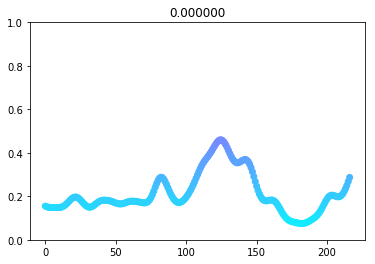

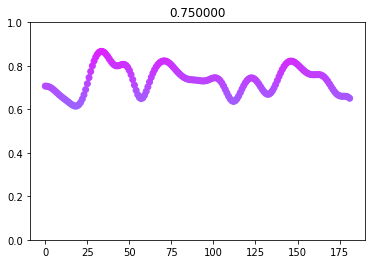

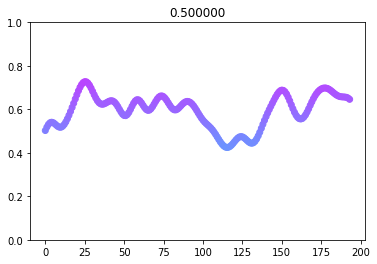

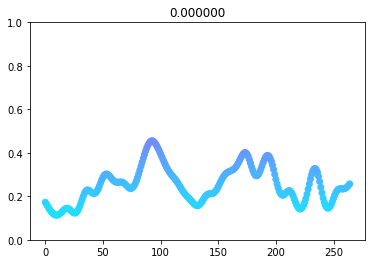

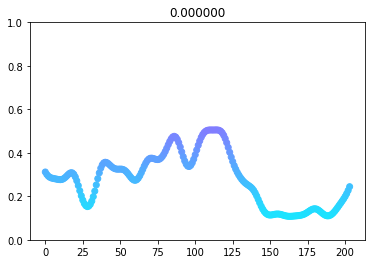

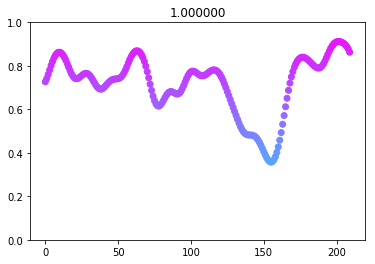

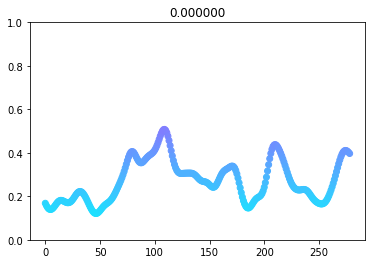

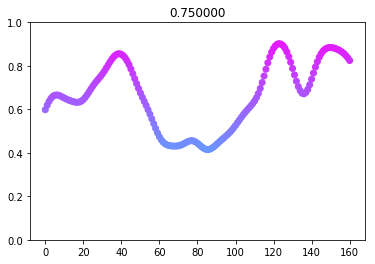

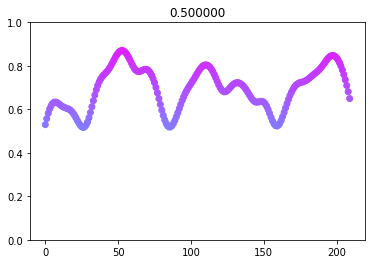

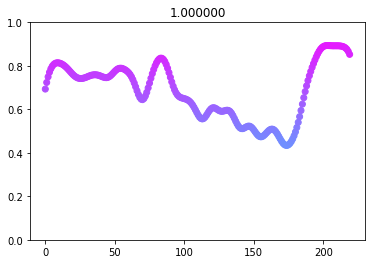

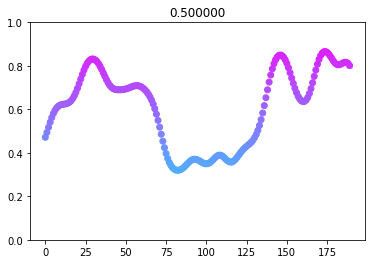

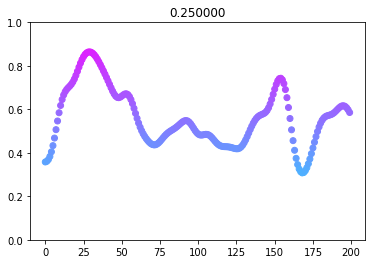

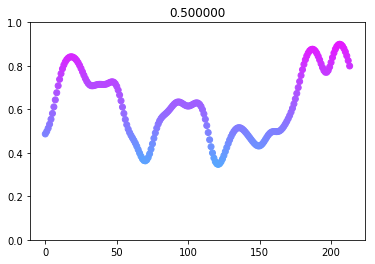

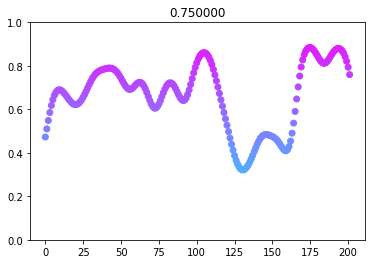

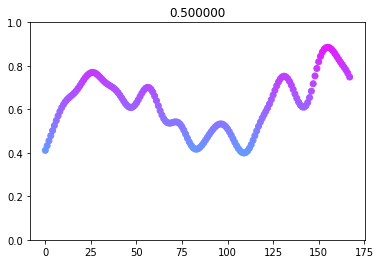

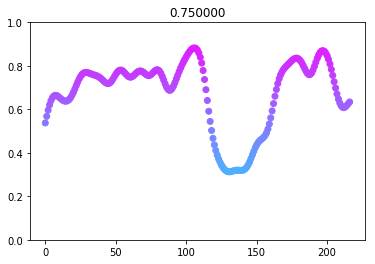

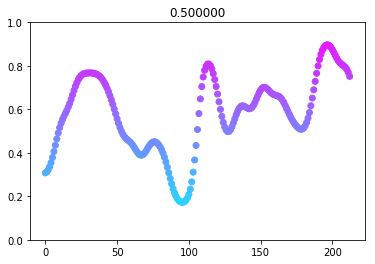

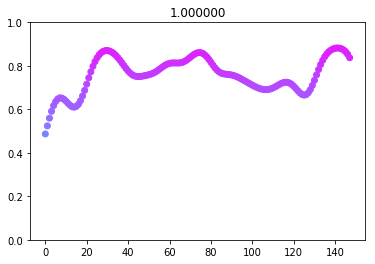

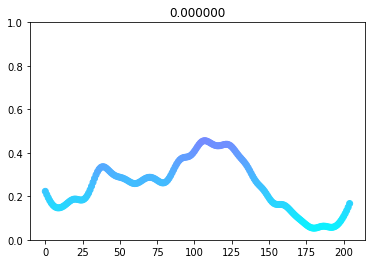

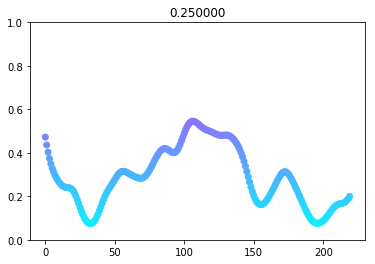

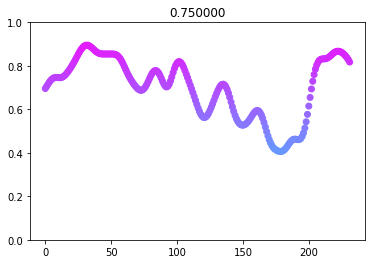

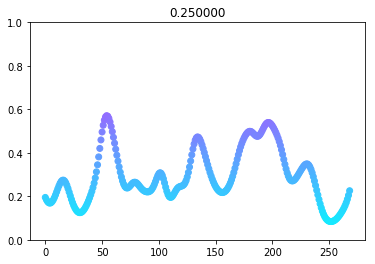

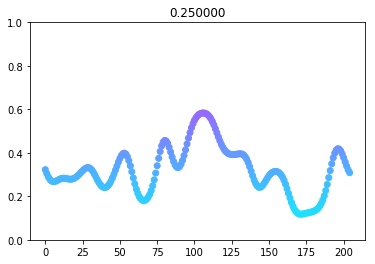

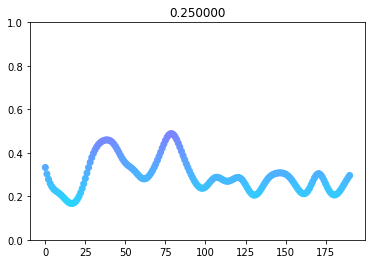

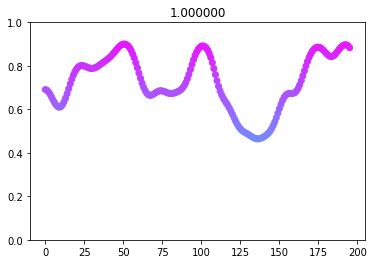

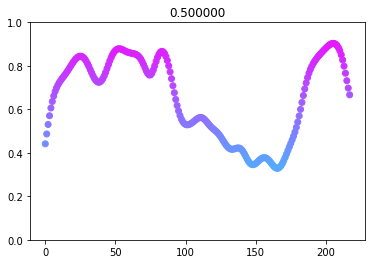

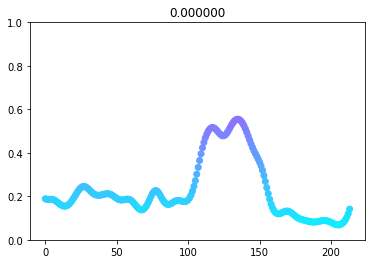

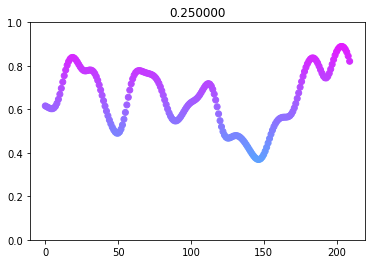

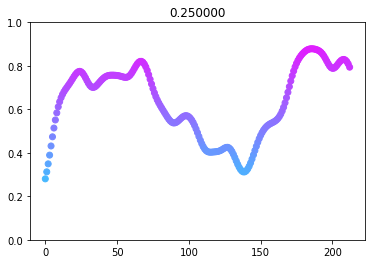

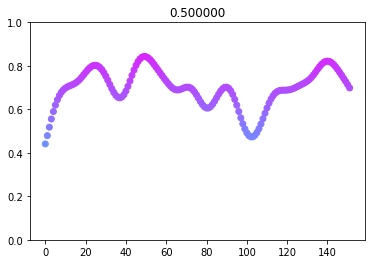

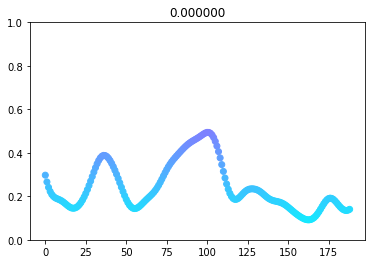

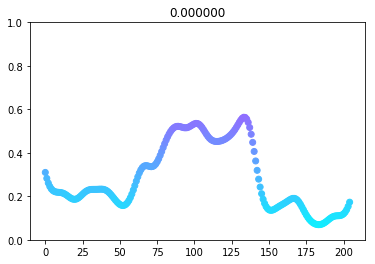

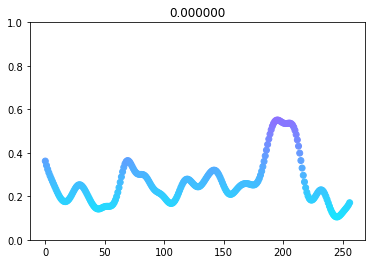

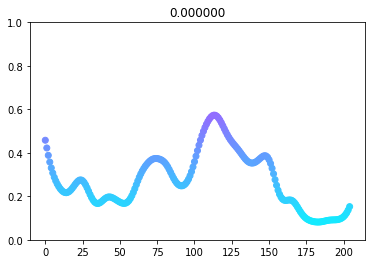

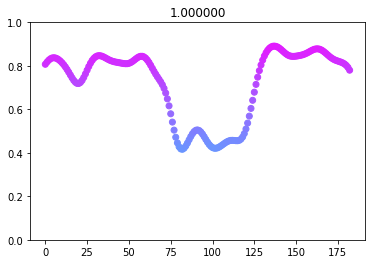

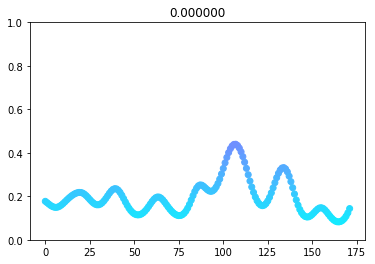

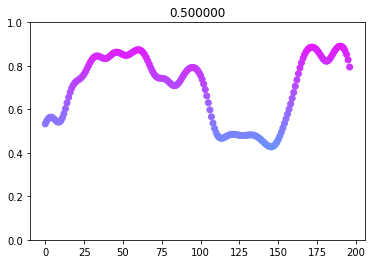

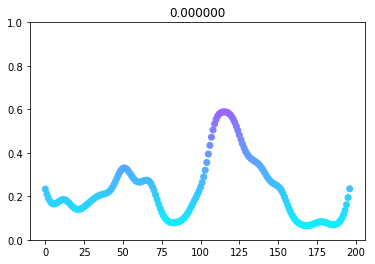

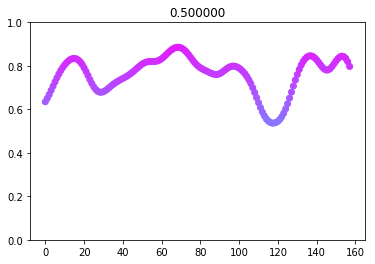

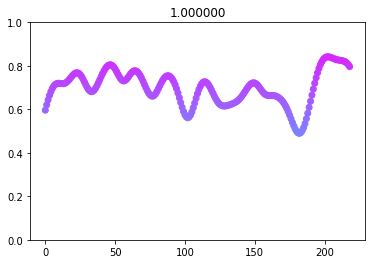

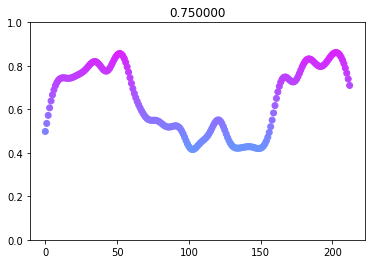

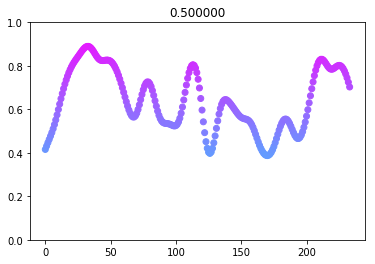

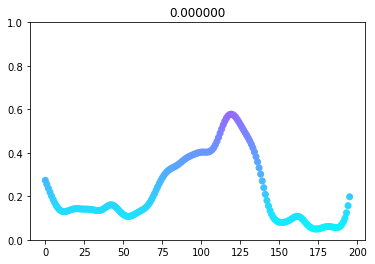

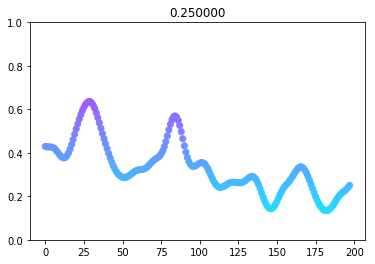

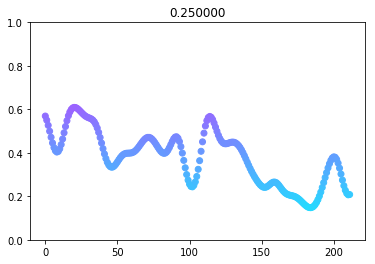

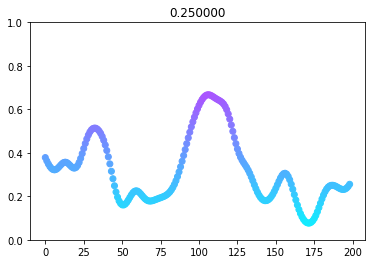

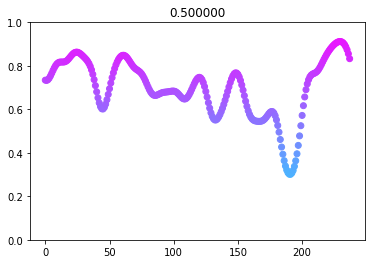

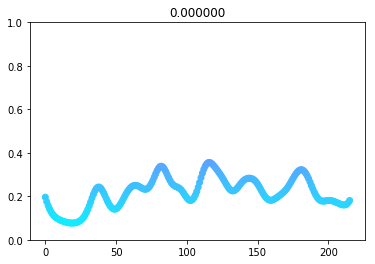

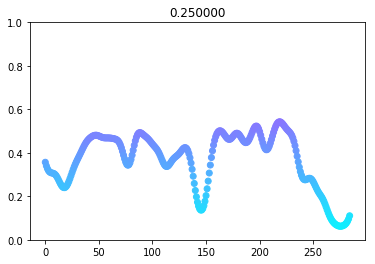

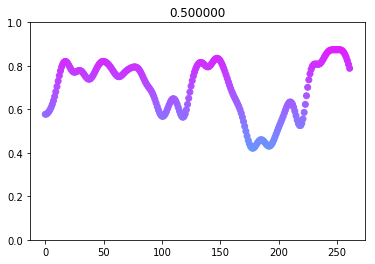

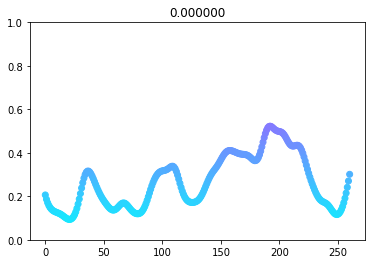

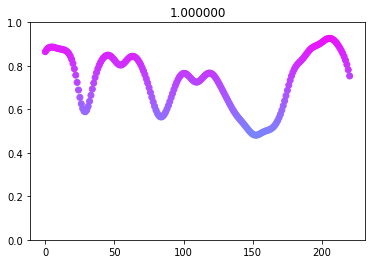

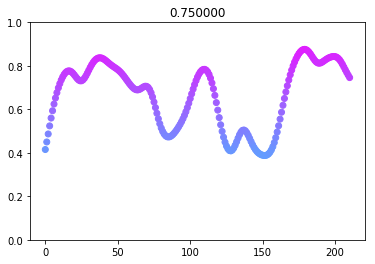

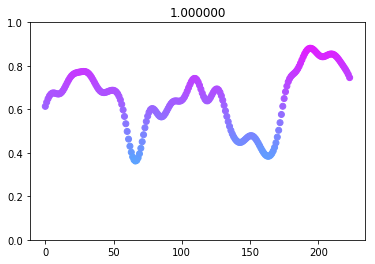

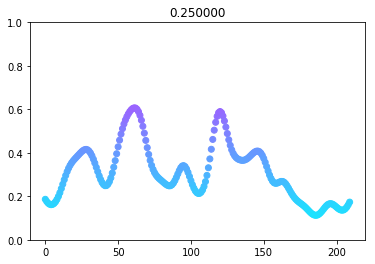

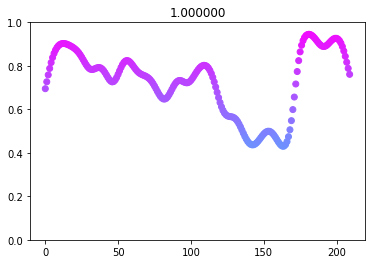

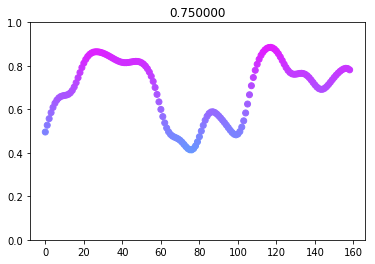

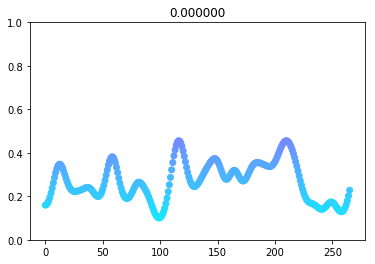

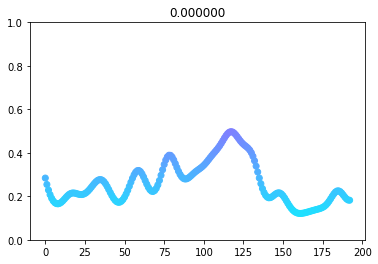

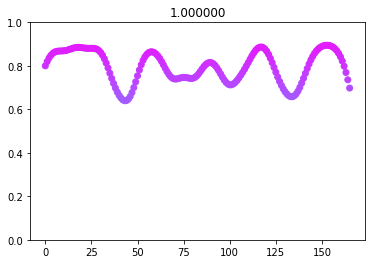

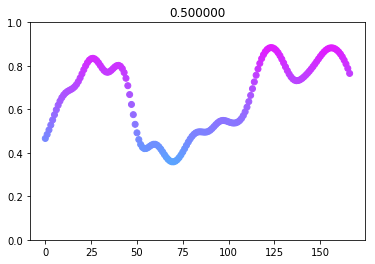

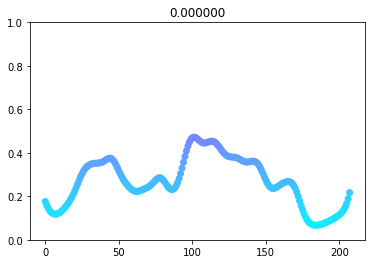

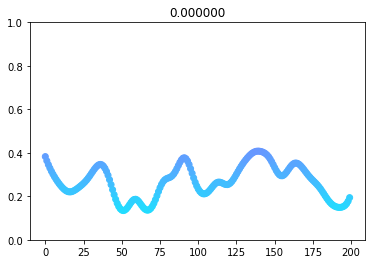

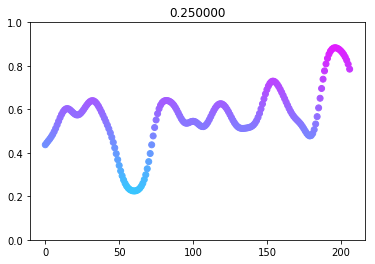

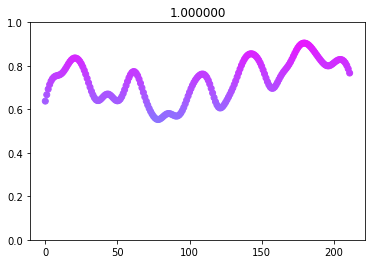

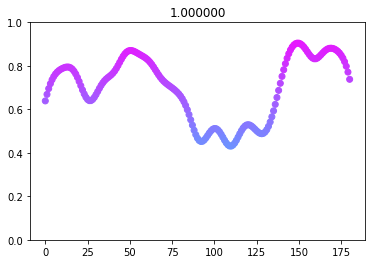

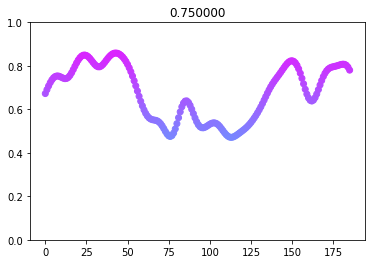

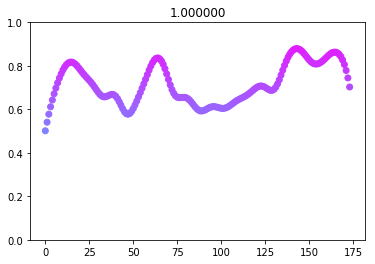

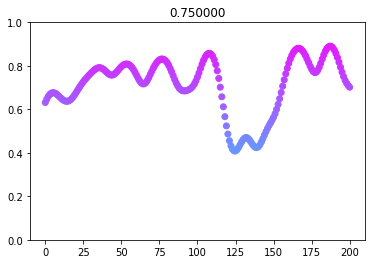

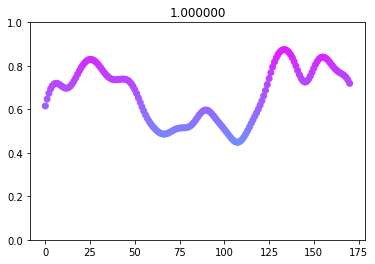

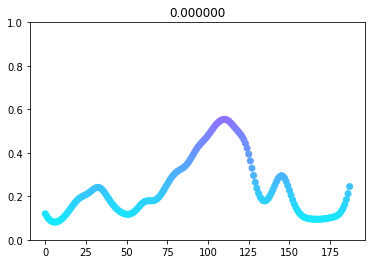

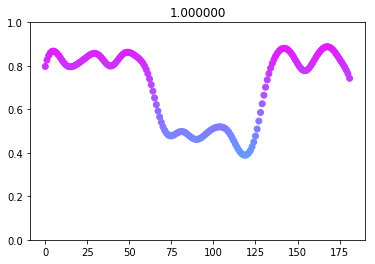

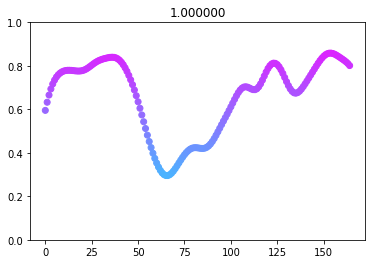

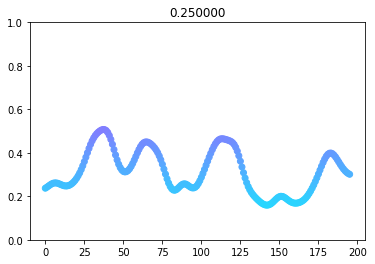

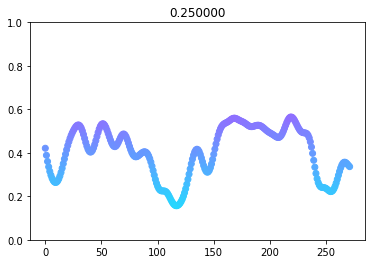

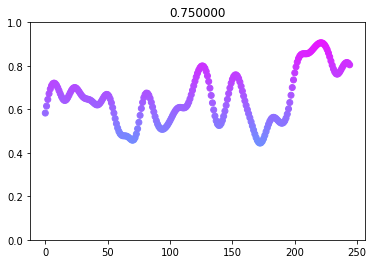

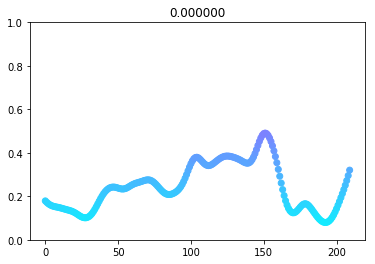

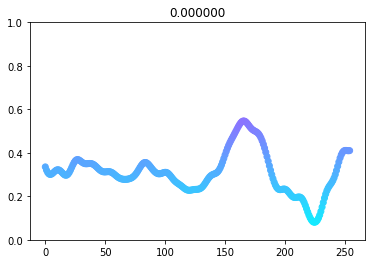

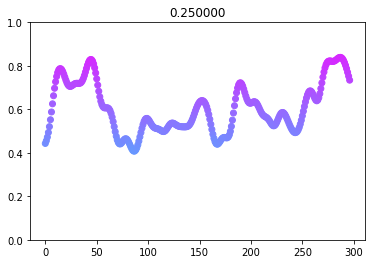

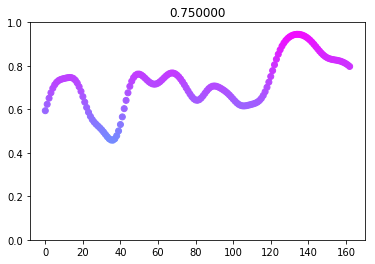

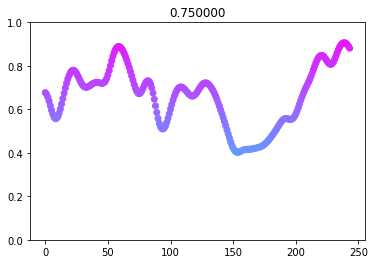

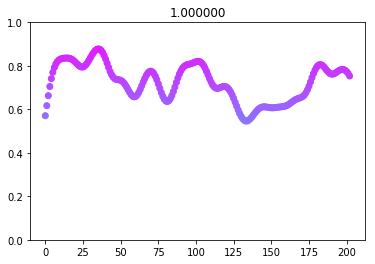

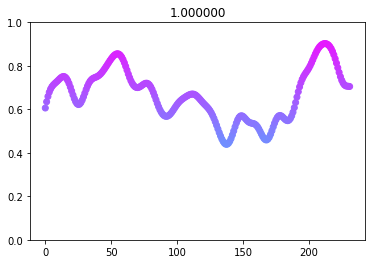

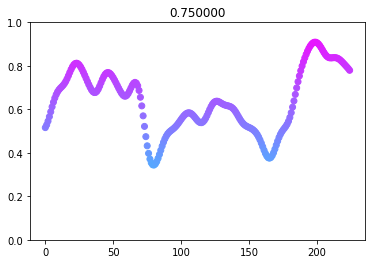

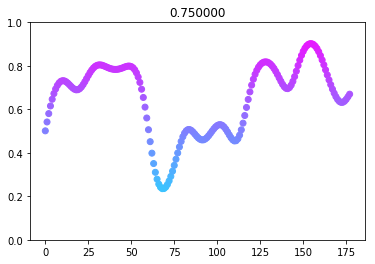

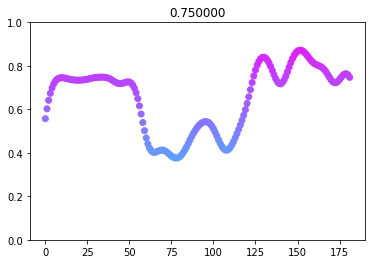

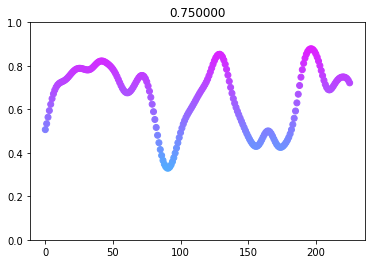

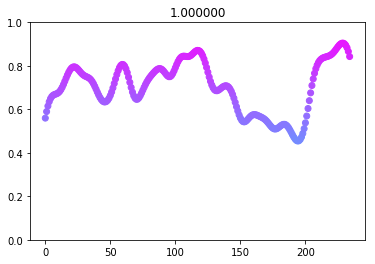

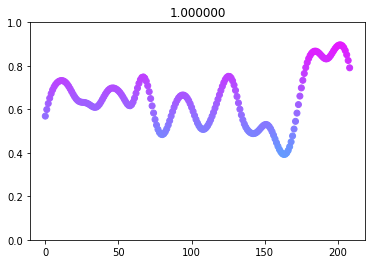

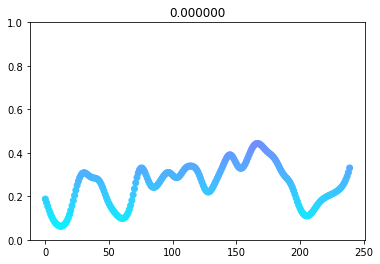

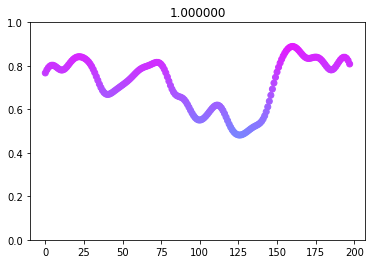

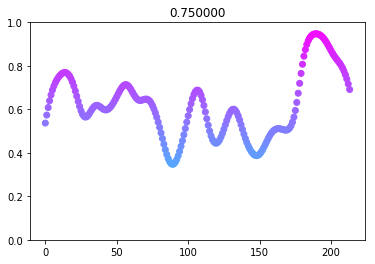

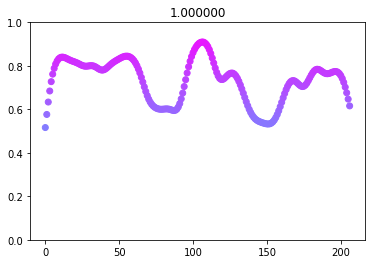

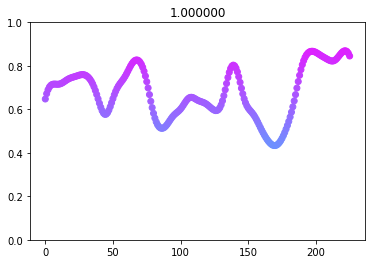

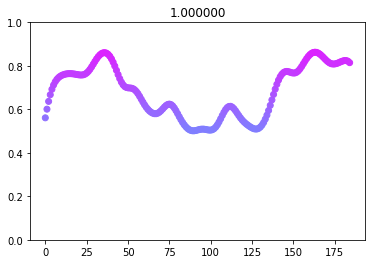

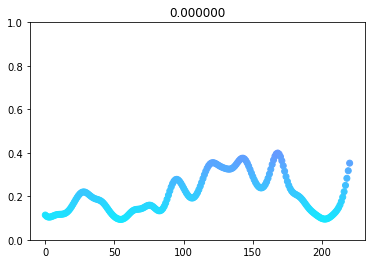

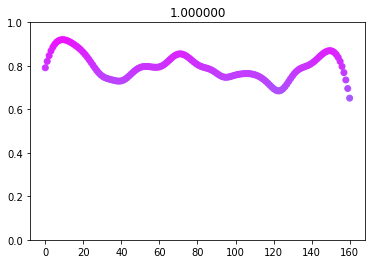

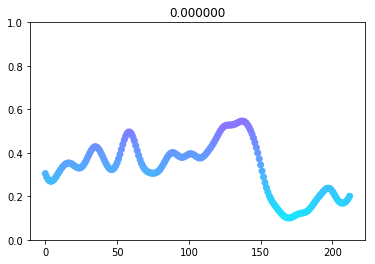

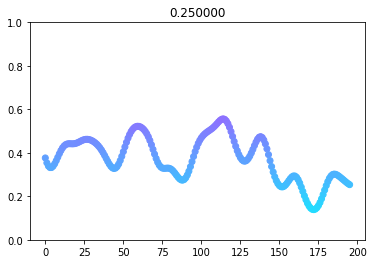

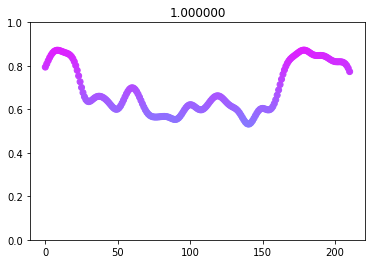

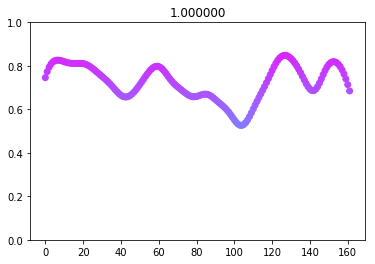

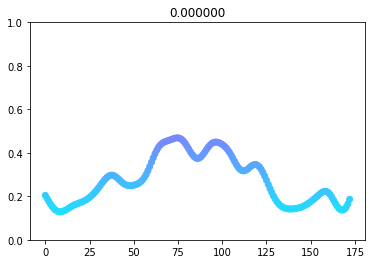

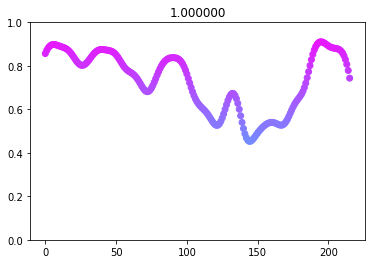

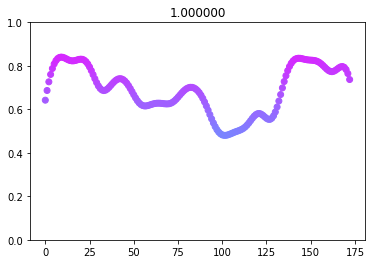

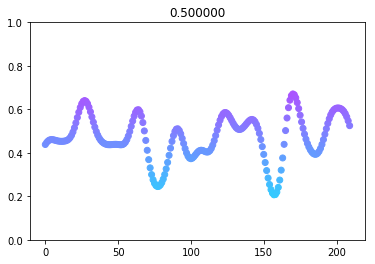

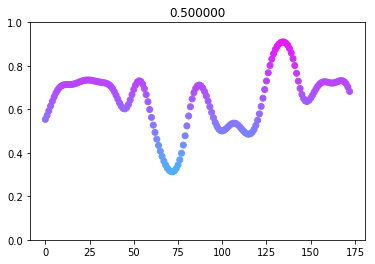

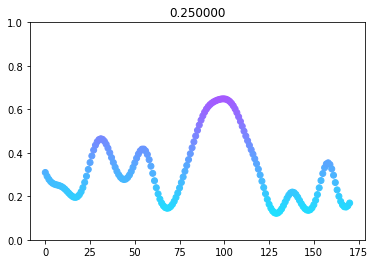

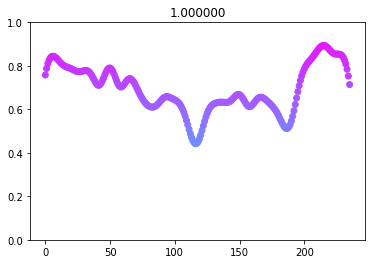

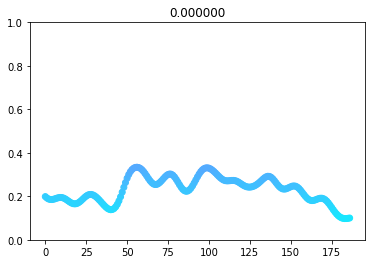

In [25]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
#     print(np.arange(stop-1-start).shape,PROJ[start:stop-1].shape)
    ax.scatter(np.arange(stop-1-start),PROJ[start:stop-1,1],c=PROJ[start:stop-1,1],cmap='cool',vmin=0,vmax=1)
#     ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
    ax.set_ylim([0,1])

In [36]:
orthbasis = PCA().fit_transform(S)
orthbasis_sm = sp.ndimage.filters.gaussian_filter1d(orthbasis,2,axis=0)
ldalist = []

for ind in np.unique(pos_binned):
    # find indices for LDA
    if ind not in (0,46):
        posmask = pos_binned == ind
        morphmask = (posmask) & ((VRDat.morph._values==0) | (VRDat.morph._values==1))
        
        
        lda = LDA()
        print(VRDat.morph._values[morphmask].shape,S[morphmask,:].shape)
        lda.fit(S[morphmask,:],VRDat.morph._values[morphmask])
        
        ldalist.append(lda)

        
    

    
    # transform LDA

(205,) (205, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(198,) (198, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(149,) (149, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(147,) (147, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(142,) (142, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(140,) (140, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(136,) (136, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(131,) (131, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(130,) (130, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(137,) (137, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(143,) (143, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(150,) (150, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(142,) (142, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(162,) (162, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(170,) (170, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(182,) (182, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(169,) (169, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(194,) (194, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(194,) (194, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(201,) (201, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(213,) (213, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(247,) (247, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(337,) (337, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(558,) (558, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(583,) (583, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(415,) (415, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(602,) (602, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(675,) (675, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(537,) (537, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(665,) (665, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(544,) (544, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(550,) (550, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(561,) (561, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(429,) (429, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(273,) (273, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(404,) (404, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(343,) (343, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(271,) (271, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(160,) (160, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(154,) (154, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(150,) (150, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(152,) (152, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(160,) (160, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(160,) (160, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(234,) (234, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [45]:
PROJ = np.zeros([S.shape[0],1])
for t in range(S.shape[0]):
    if pos_binned[t]>0 and pos_binned[t]<46:
#         PROJ[t] = ldalist[inds[t]].predict_proba(S[t,:].reshape(1,-1))[:,1]
        PROJ[t] = ldalist[inds[t]].transform(S[t,:].reshape(1,-1))
        


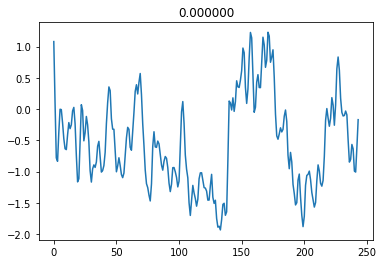

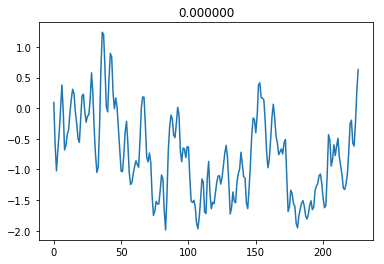

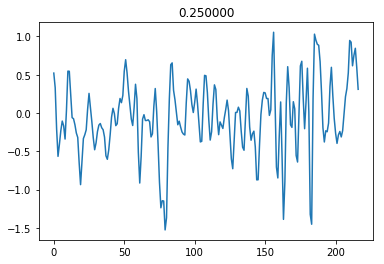

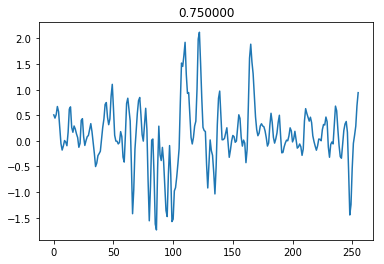

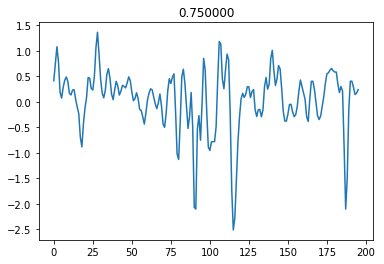

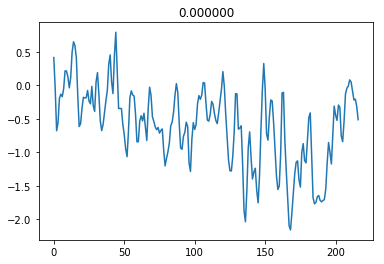

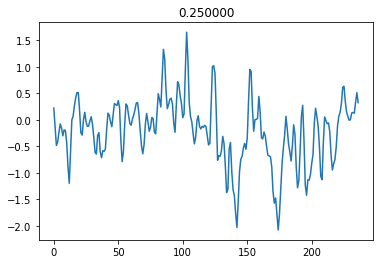

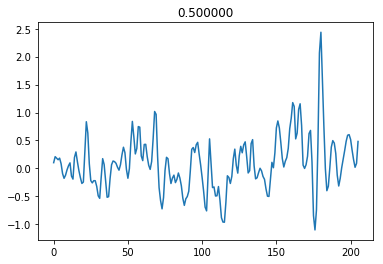

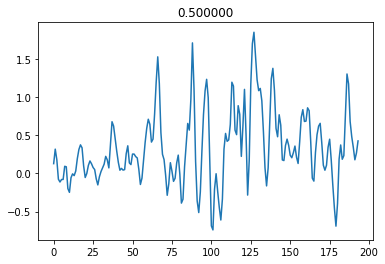

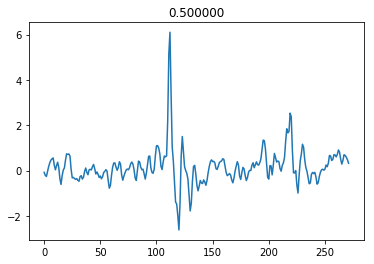

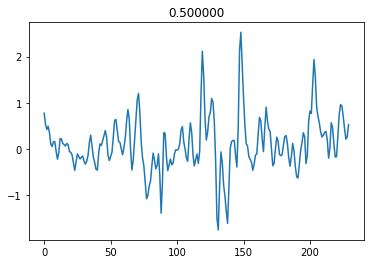

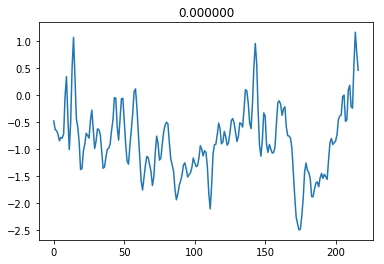

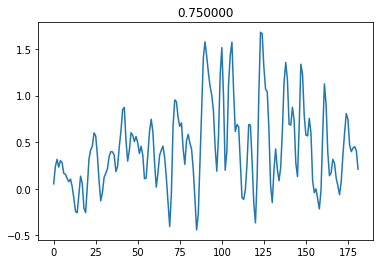

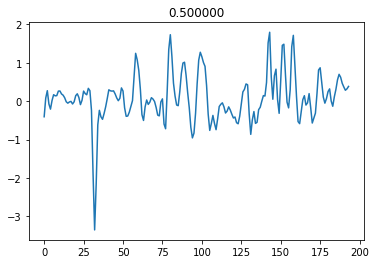

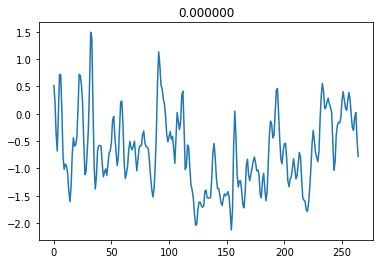

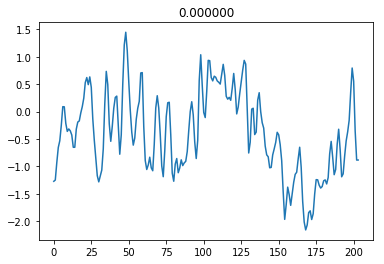

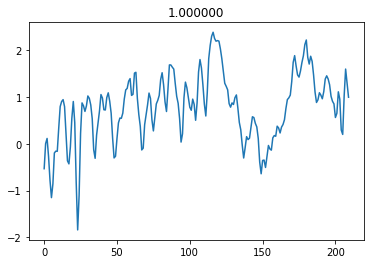

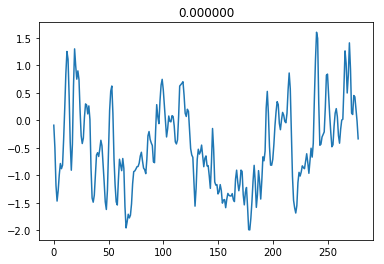

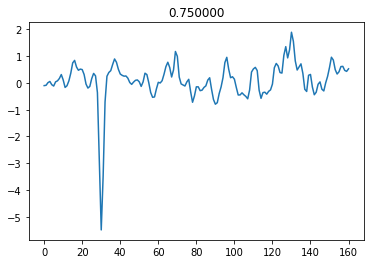

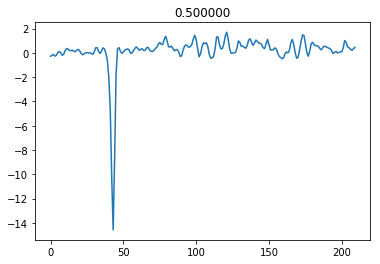

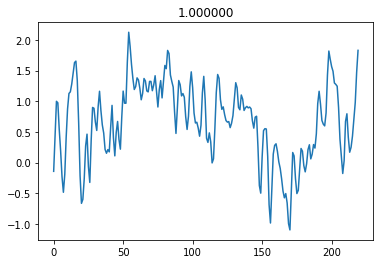

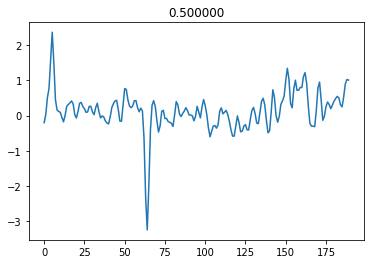

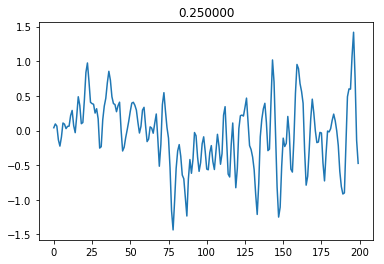

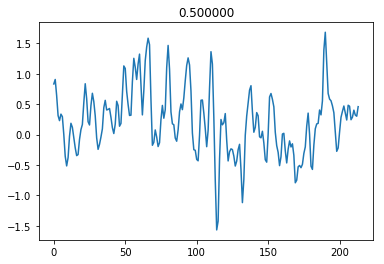

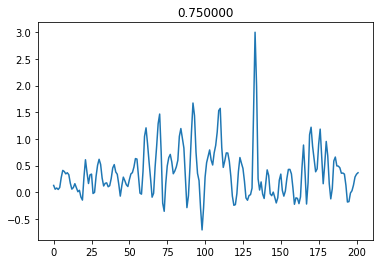

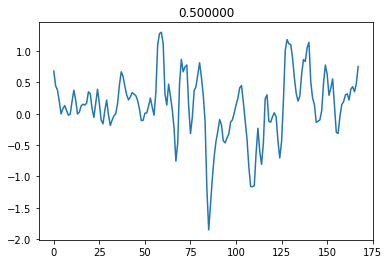

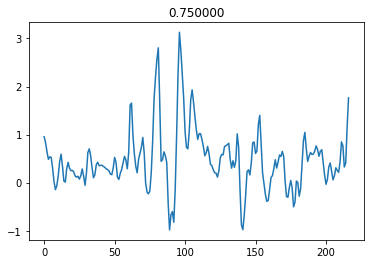

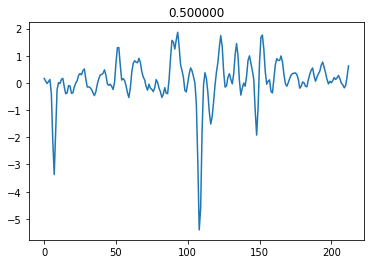

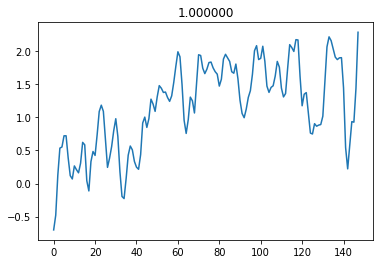

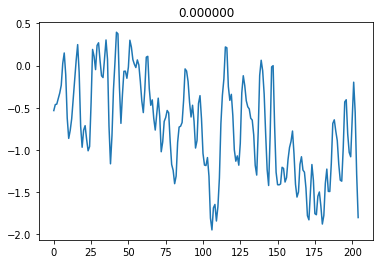

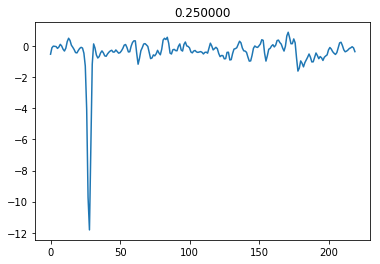

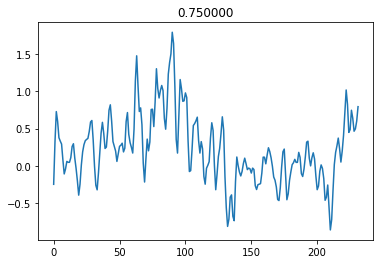

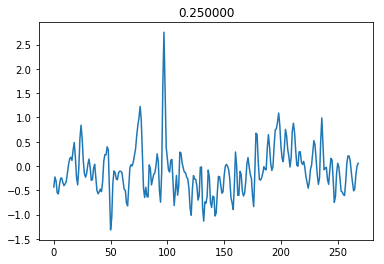

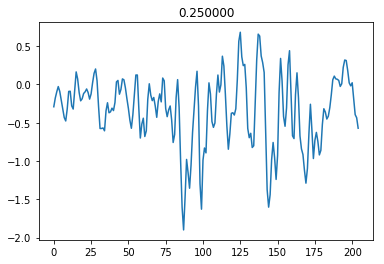

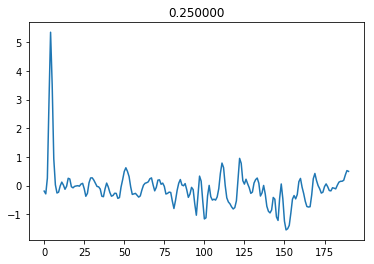

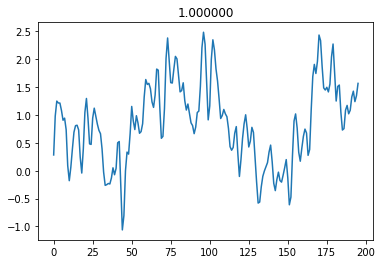

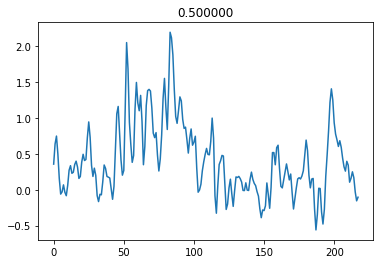

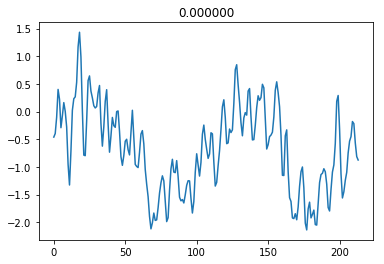

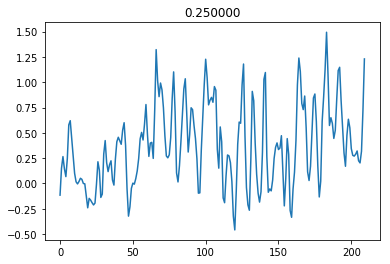

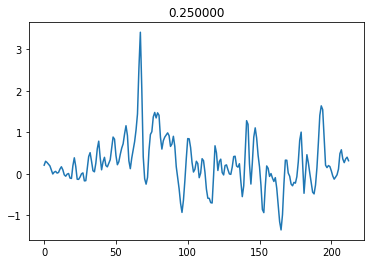

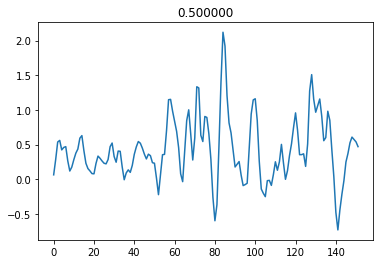

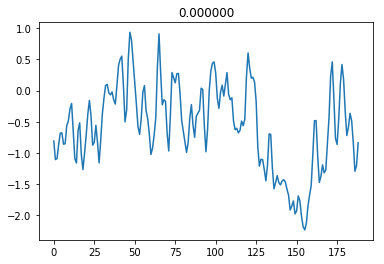

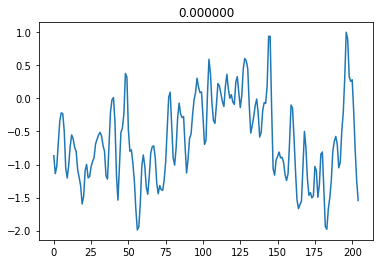

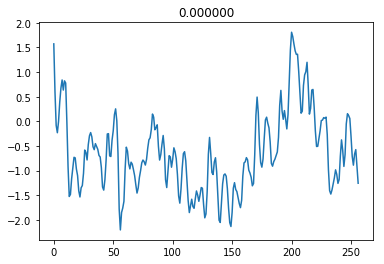

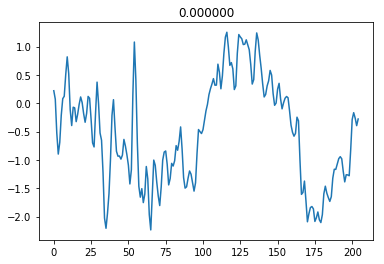

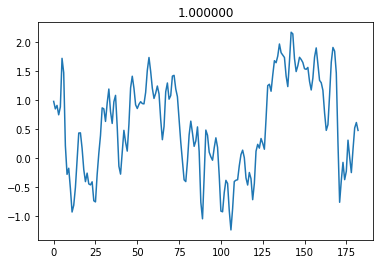

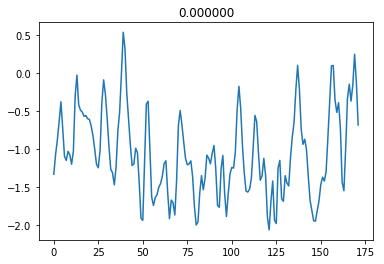

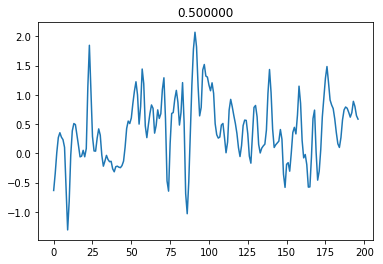

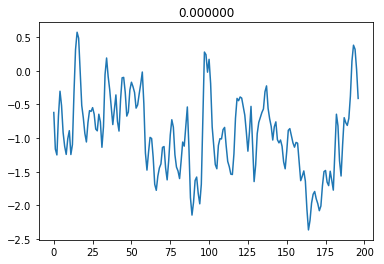

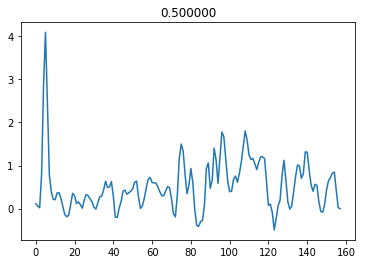

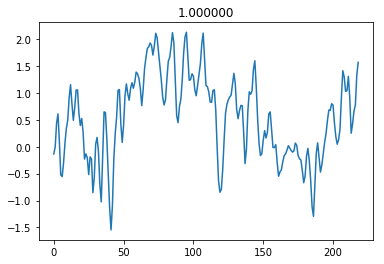

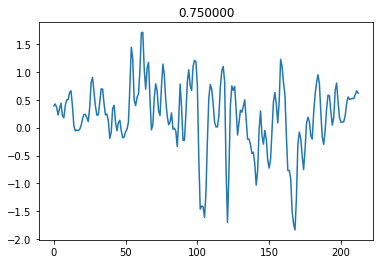

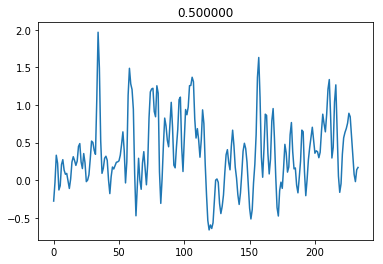

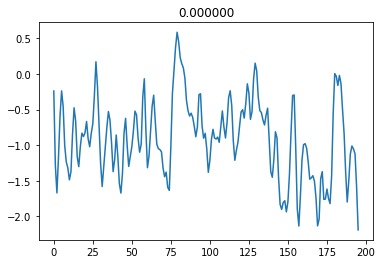

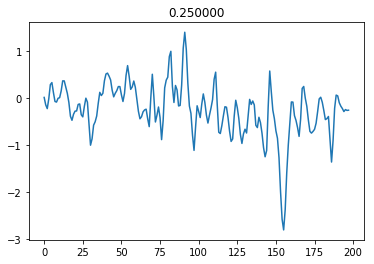

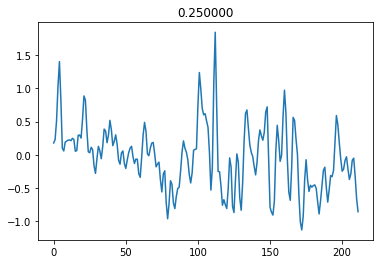

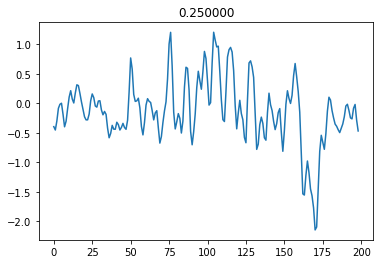

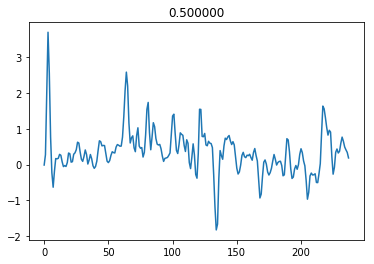

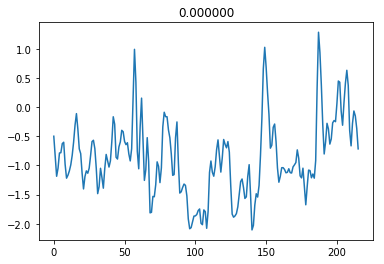

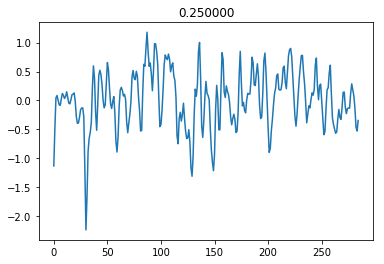

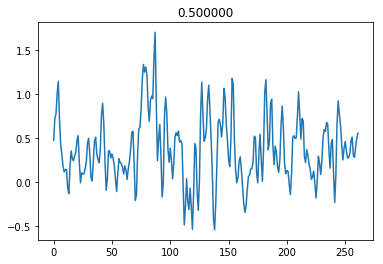

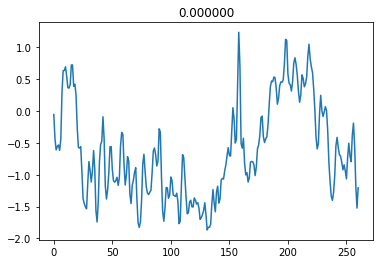

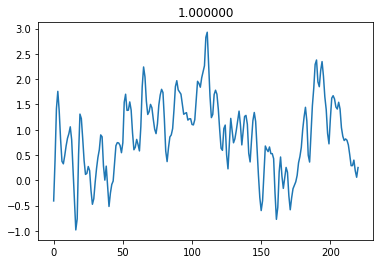

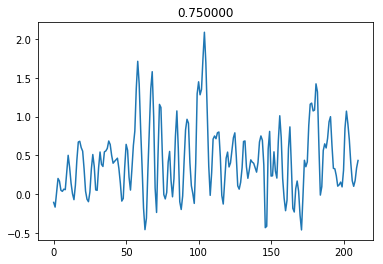

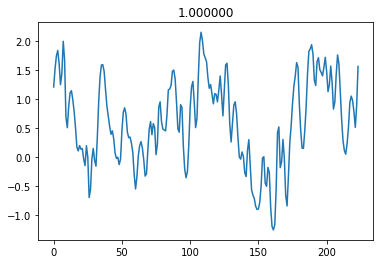

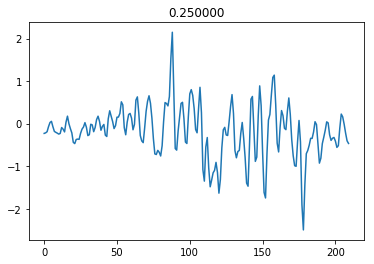

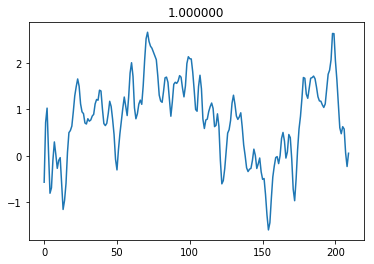

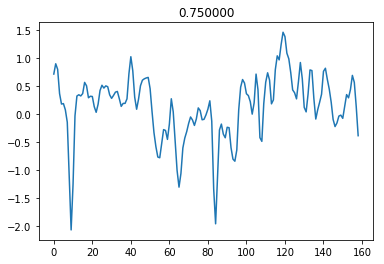

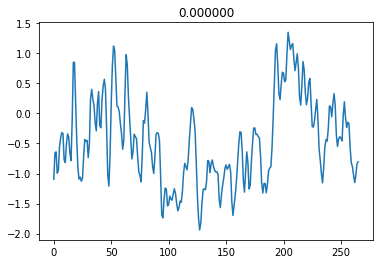

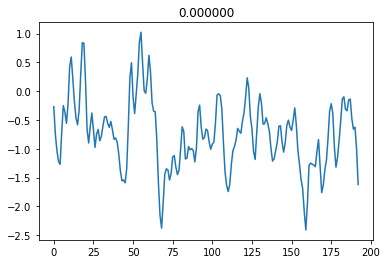

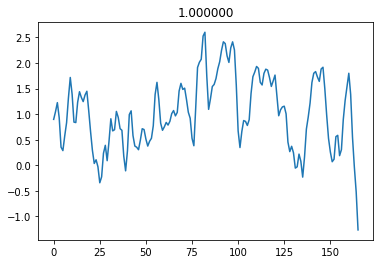

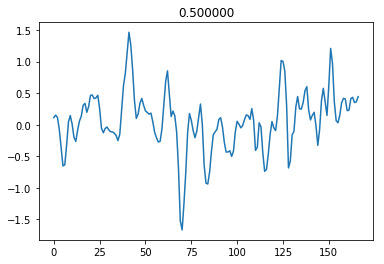

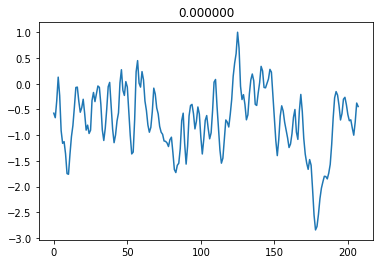

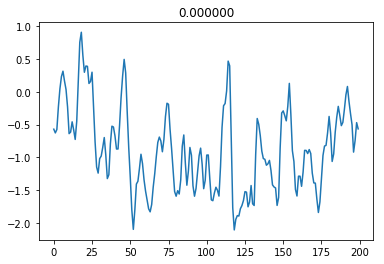

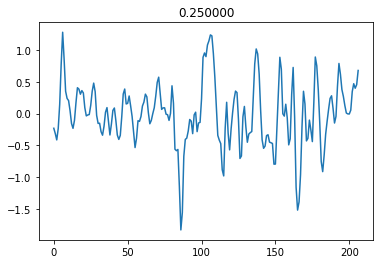

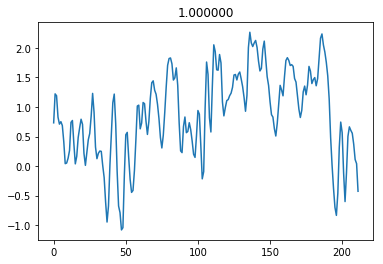

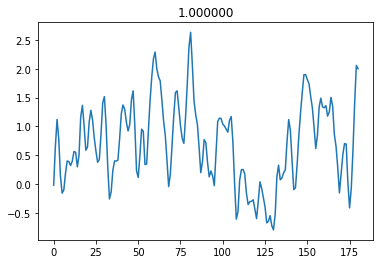

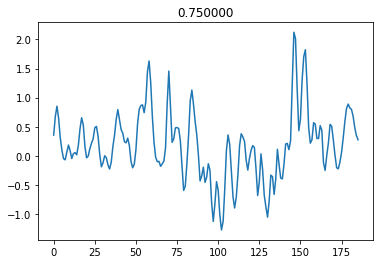

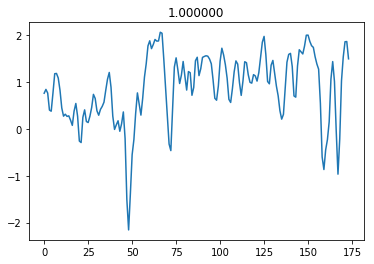

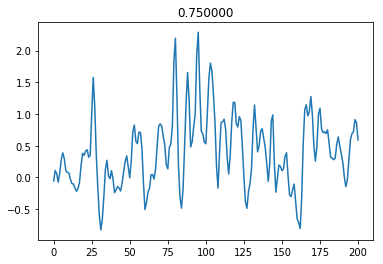

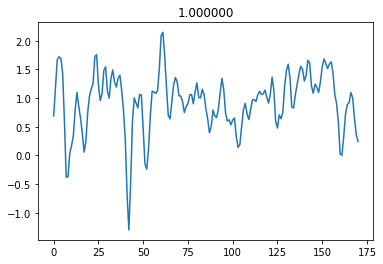

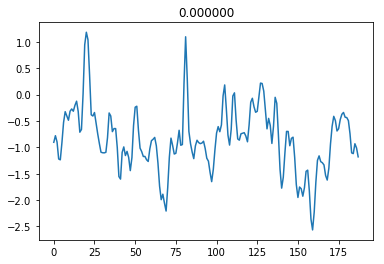

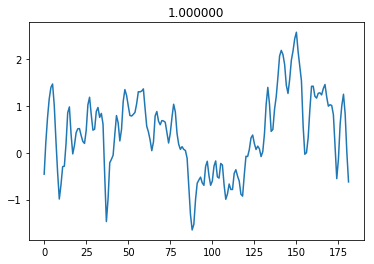

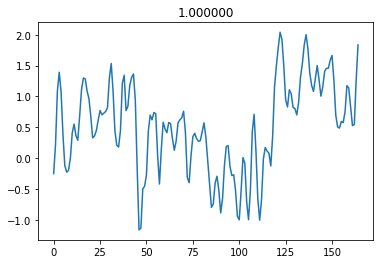

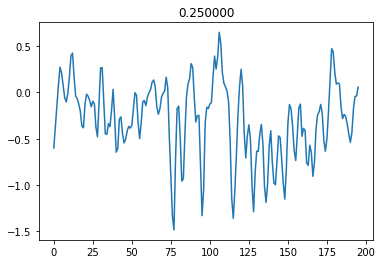

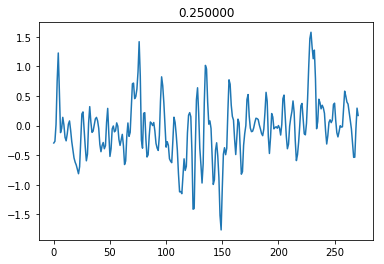

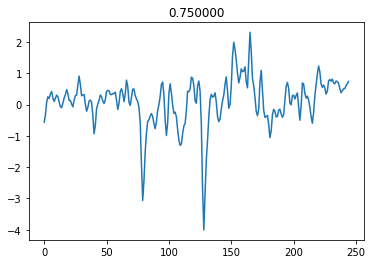

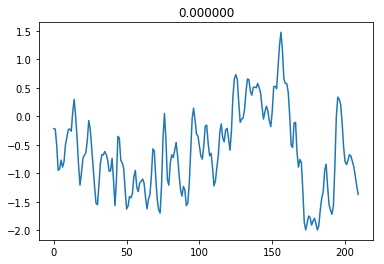

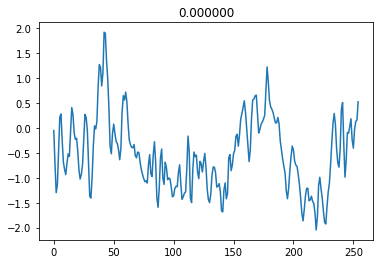

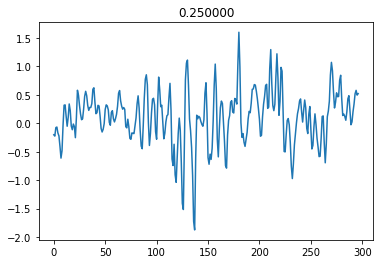

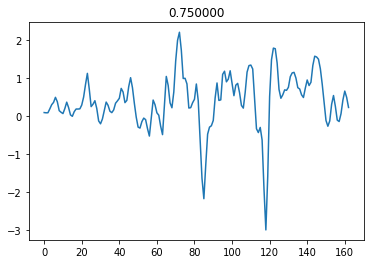

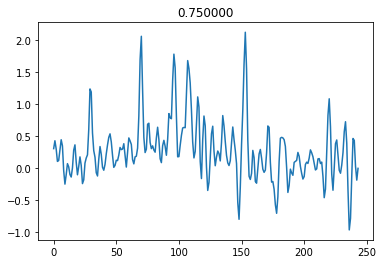

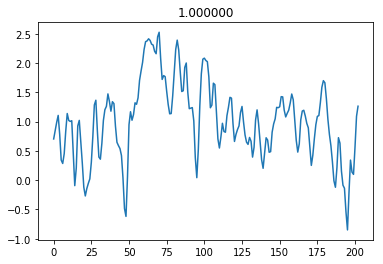

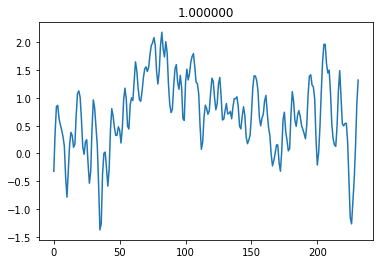

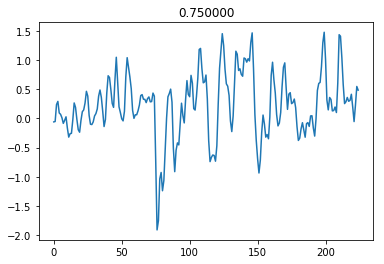

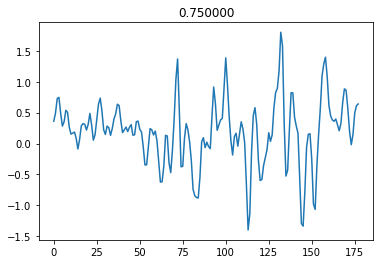

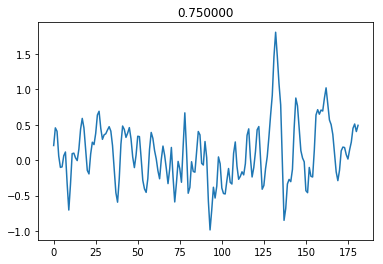

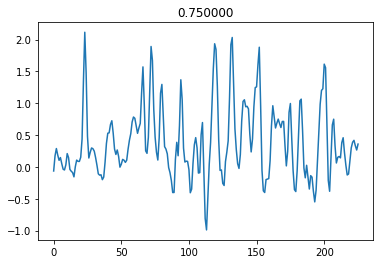

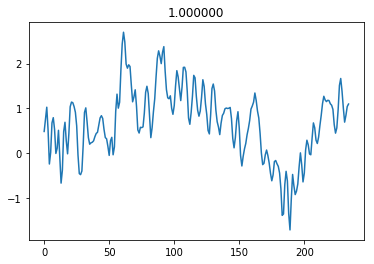

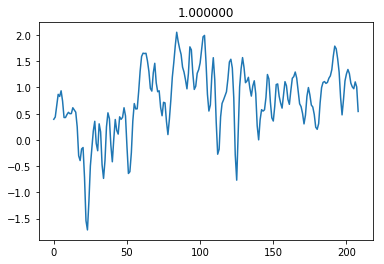

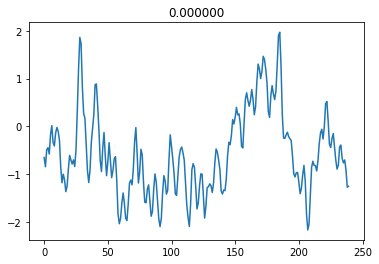

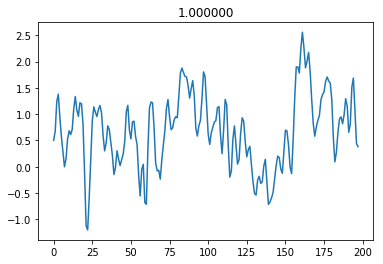

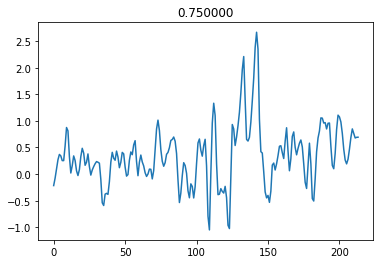

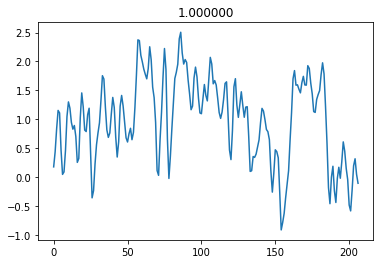

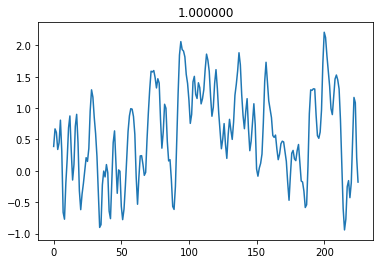

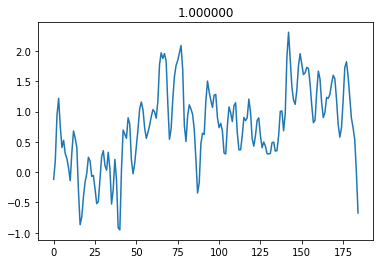

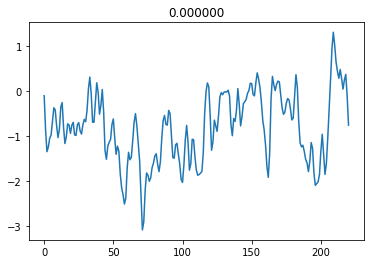

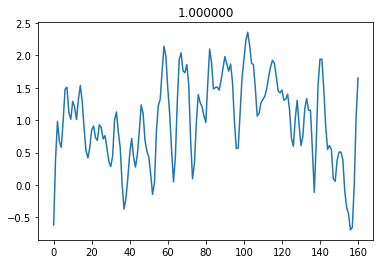

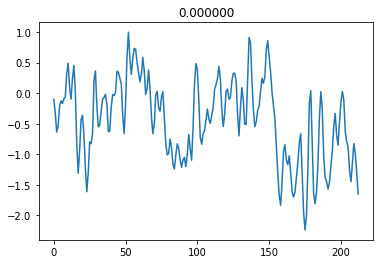

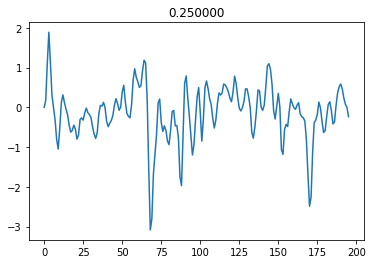

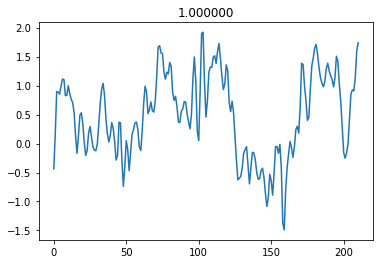

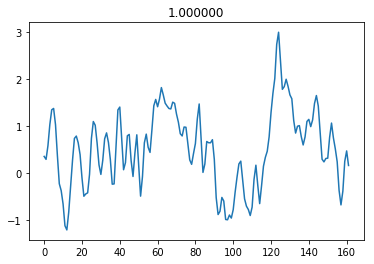

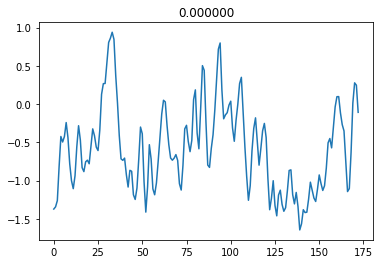

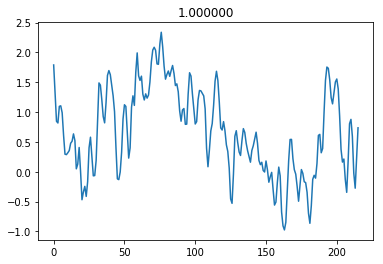

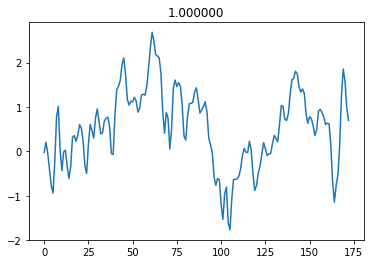

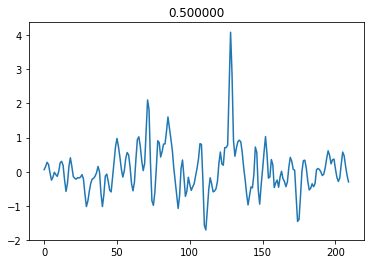

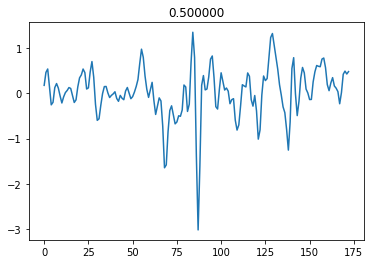

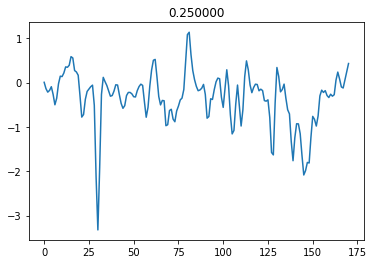

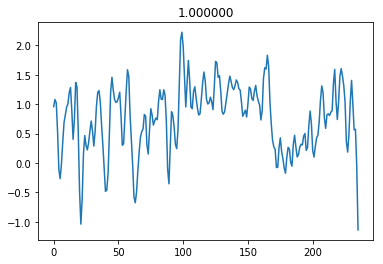

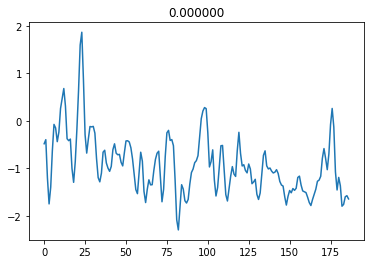

In [47]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.plot(np.arange(stop-1-start),sp.ndimage.filters.gaussian_filter1d(PROJ[start:stop-1].ravel(),1))
#     ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
#     ax.axhline(.5,xmin=0,xmax=stop-1-start,color='red')
#     ax.set_ylim([0,1])

In [60]:
P_trial_mat = u.make_pos_bin_trial_matrices(PROJ,VRDat.pos._values,tstart_inds,teleport_inds,bin_size=10,mat_only=True)

In [61]:
P_dict = u.trial_type_dict(P_trial_mat,trial_info['morphs'])
xarr = np.linspace(0,450,num=P_trial_mat.shape[1])

In [62]:
print(P_dict[0].shape)

(30, 45)


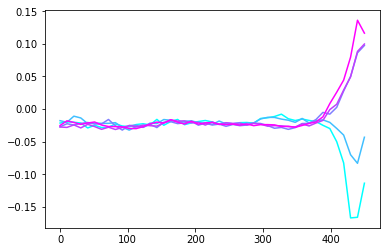

In [63]:
f,ax = plt.subplots()#,figsize=[10,10])
for i,m in enumerate([0,.25,.5,.75,1.]):
    ax.plot(xarr,P_dict[m].mean(axis=0),color=plt.cm.cool(m))